In [1]:
import seaborn as sns
from transformers import BertModel, BertTokenizer
import json
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fasttext
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from itertools import chain
from scipy.special import binom
plt.style.use('seaborn')

C:\Users\Melvin\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Melvin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\Melvin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#Globale Parameter
titleFontSize = 18
labelFontSize = 15
figsize = (13,7)
dpi = 300
legendSize = 13

In [3]:
#Daten laden
with open("Data/Data.json",encoding='utf-8') as file:
    data = json.load(file)

with open("Data/Queries.json",encoding='utf-8') as file:
    queries = json.load(file)
    
#Stopwörter und Lemmatizer laden
german_stopwords = stopwords.words('german')
lemmatizer = spacy.load('de_core_news_sm')

#Word2Vec Model laden
w2vModel = fasttext.load_model('Data/Word2Vec/cc.de.300.bin')

#Bert Tokenizer laden
bert_tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-german-uncased')

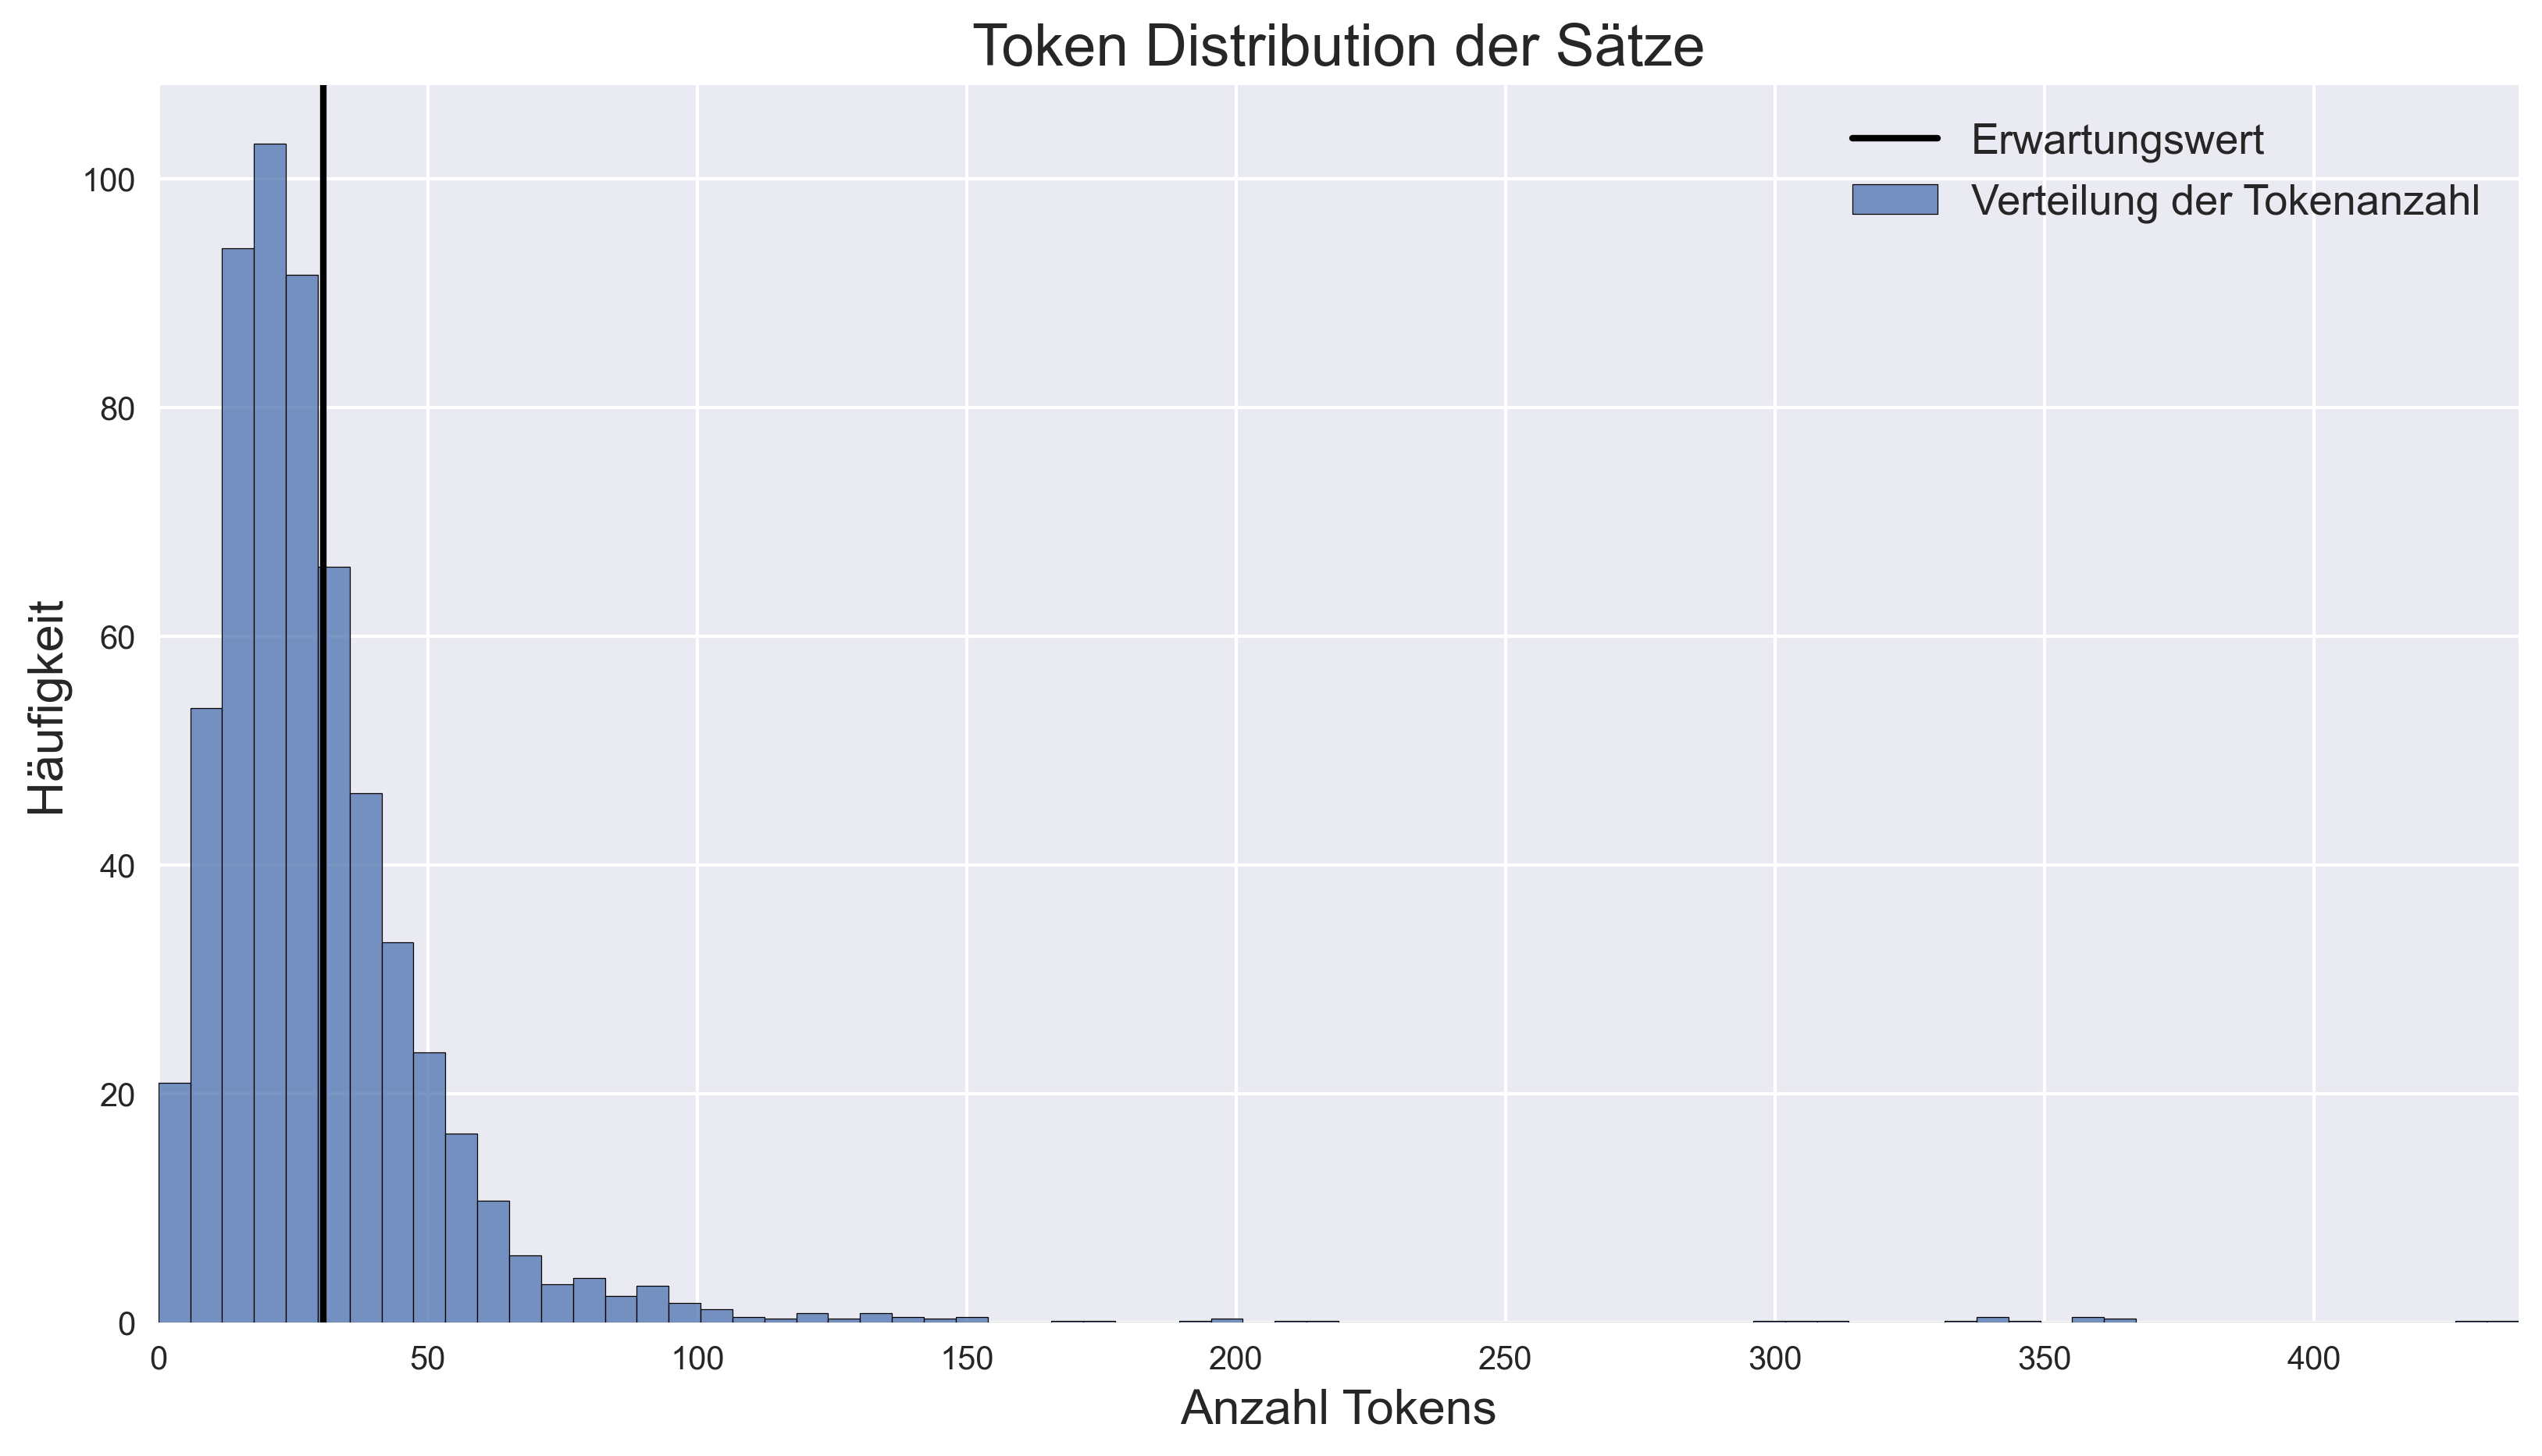

Min: 2, Mean: 30.643922018348626, Max: 438


In [4]:
# Länge der Sätze nach Bert-Tokenization plotten (für Visualisierung wegen max 512 Tokens)

# Preprocessing der PDF-Texte
def preprocessing(text):
    text = text.lower()
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = sent_tokenize(text, language='german')
    text = [re.sub('[^a-zA-ZäöüÄÖÜß]', ' ', sentence) for sentence in text]
    return text

#Daten bereinigen
preprocessedData = dict()
for key,value in data.items():
    preprocessedData[key] = preprocessing(value['content'])

token_lens = []
for txt in preprocessedData.values():
    for sentence in txt:
        tokens = bert_tokenizer.encode(sentence, max_length=512,truncation=True)
        token_lens.append(len(tokens))
        
mean = np.mean(token_lens)
maxLen = np.max(token_lens)
minLen = np.min(token_lens)

#sns.displot(token_lens,label='Verteilung der Tokenanzahl',bins=np.linspace(0,maxLen,50),rug=True)
plt.figure(figsize=figsize,dpi=dpi)
sns.histplot(token_lens,label='Verteilung der Tokenanzahl',bins=np.linspace(0,maxLen,75),stat='frequency')
plt.axvline(x=mean,label='Erwartungswert',lw=2,color='black')
plt.title('Token Distribution der Sätze',fontsize=titleFontSize)
plt.legend(prop={'size':legendSize})
plt.xlim([0, maxLen])
plt.xlabel('Anzahl Tokens',fontsize=labelFontSize)
plt.ylabel('Häufigkeit',fontsize=labelFontSize)
plt.savefig("Matplots/Anzahl Satztokens Verteilung.png",bbox_inches='tight')
plt.show()

print(f'Min: {minLen}, Mean: {mean}, Max: {maxLen}')

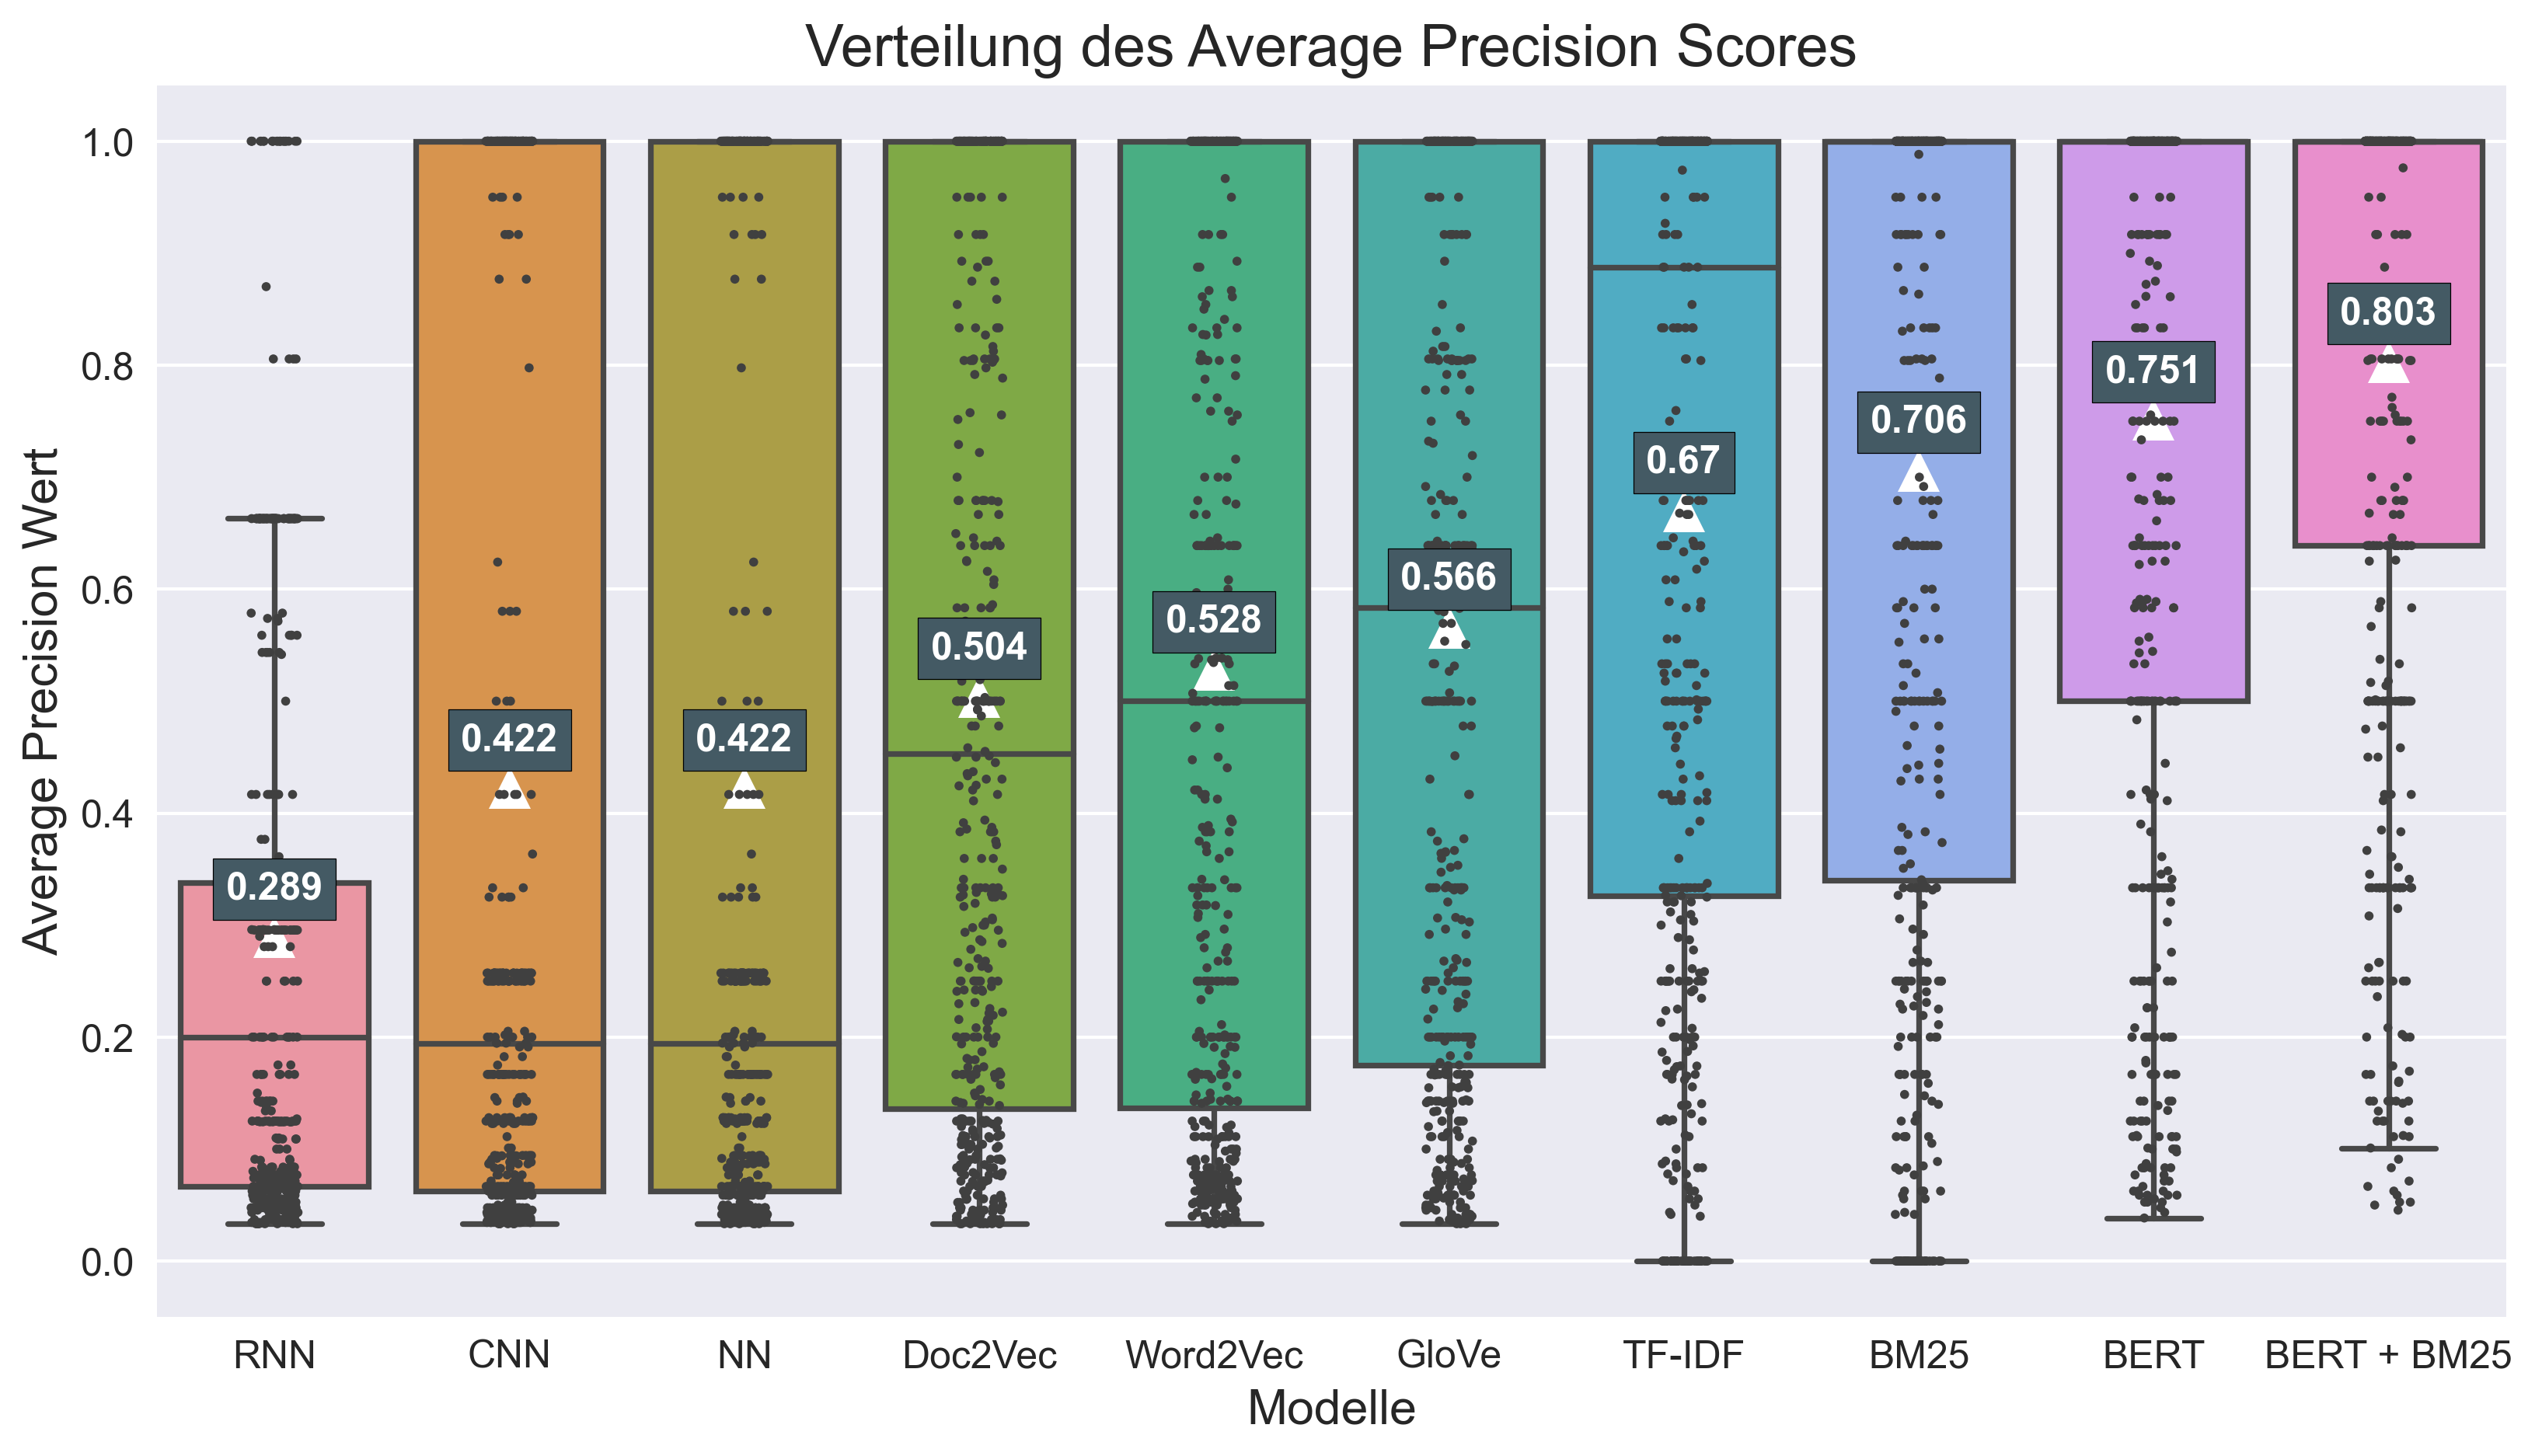

In [5]:
#MAP Ergebnisse plotten

#AllPredictions laden
with open("Data/Visualization/Predictions.json",encoding='utf-8') as file:
    allPredictions = json.load(file)

allScores = list(allPredictions.values())
modell,mapScores,mrrScores = [],[],[]
for pairs in allScores:
    for model, s in pairs.items():
        modell.append(model)
        mapScores.append(s['MAP'])
        mrrScores.append(s['MRR'])
        
columns = {'Modell' : modell,
          'AP' : mapScores}
boxesMAP = pd.DataFrame(columns)

xticksOrder = {8: 'BERT', 7:'BM25' ,9: 'BERT + BM25',
               6: 'TF-IDF', 4: 'Word2Vec', 2: 'NN', 5:'GloVe', 3:'Doc2Vec',0:'RNN',1:'CNN'}

meanprops=dict(markerfacecolor='white',markersize=13)

fig, ax = plt.subplots(figsize=figsize,dpi=dpi)
box_plot  = sns.boxplot(x="Modell", y="AP", data=boxesMAP, showfliers = False,ax=ax,showmeans=True,
                        meanprops=meanprops)
sns.stripplot(x="Modell", y="AP", data=boxesMAP,ax=ax,color=".25",size=2.8)

medians = np.round(boxesMAP.groupby(['Modell'])['AP'].median(),3)
maps = np.round(boxesMAP.groupby(['Modell'])['AP'].mean(),3)
vertical_offset = boxesMAP['AP'].mean() * 0.06

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,maps[xticksOrder[xtick]] + vertical_offset, maps[xticksOrder[xtick]],
                    horizontalalignment='center',size=12,color='w',weight='semibold',bbox=dict(facecolor='#445A64'))
    

plt.title('Verteilung des Average Precision Scores',fontsize=titleFontSize)
plt.xlabel('Modelle',fontsize=labelFontSize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Average Precision Wert',fontsize=labelFontSize)
plt.savefig("Matplots/AP Verteilung.png",bbox_inches='tight')
plt.show()

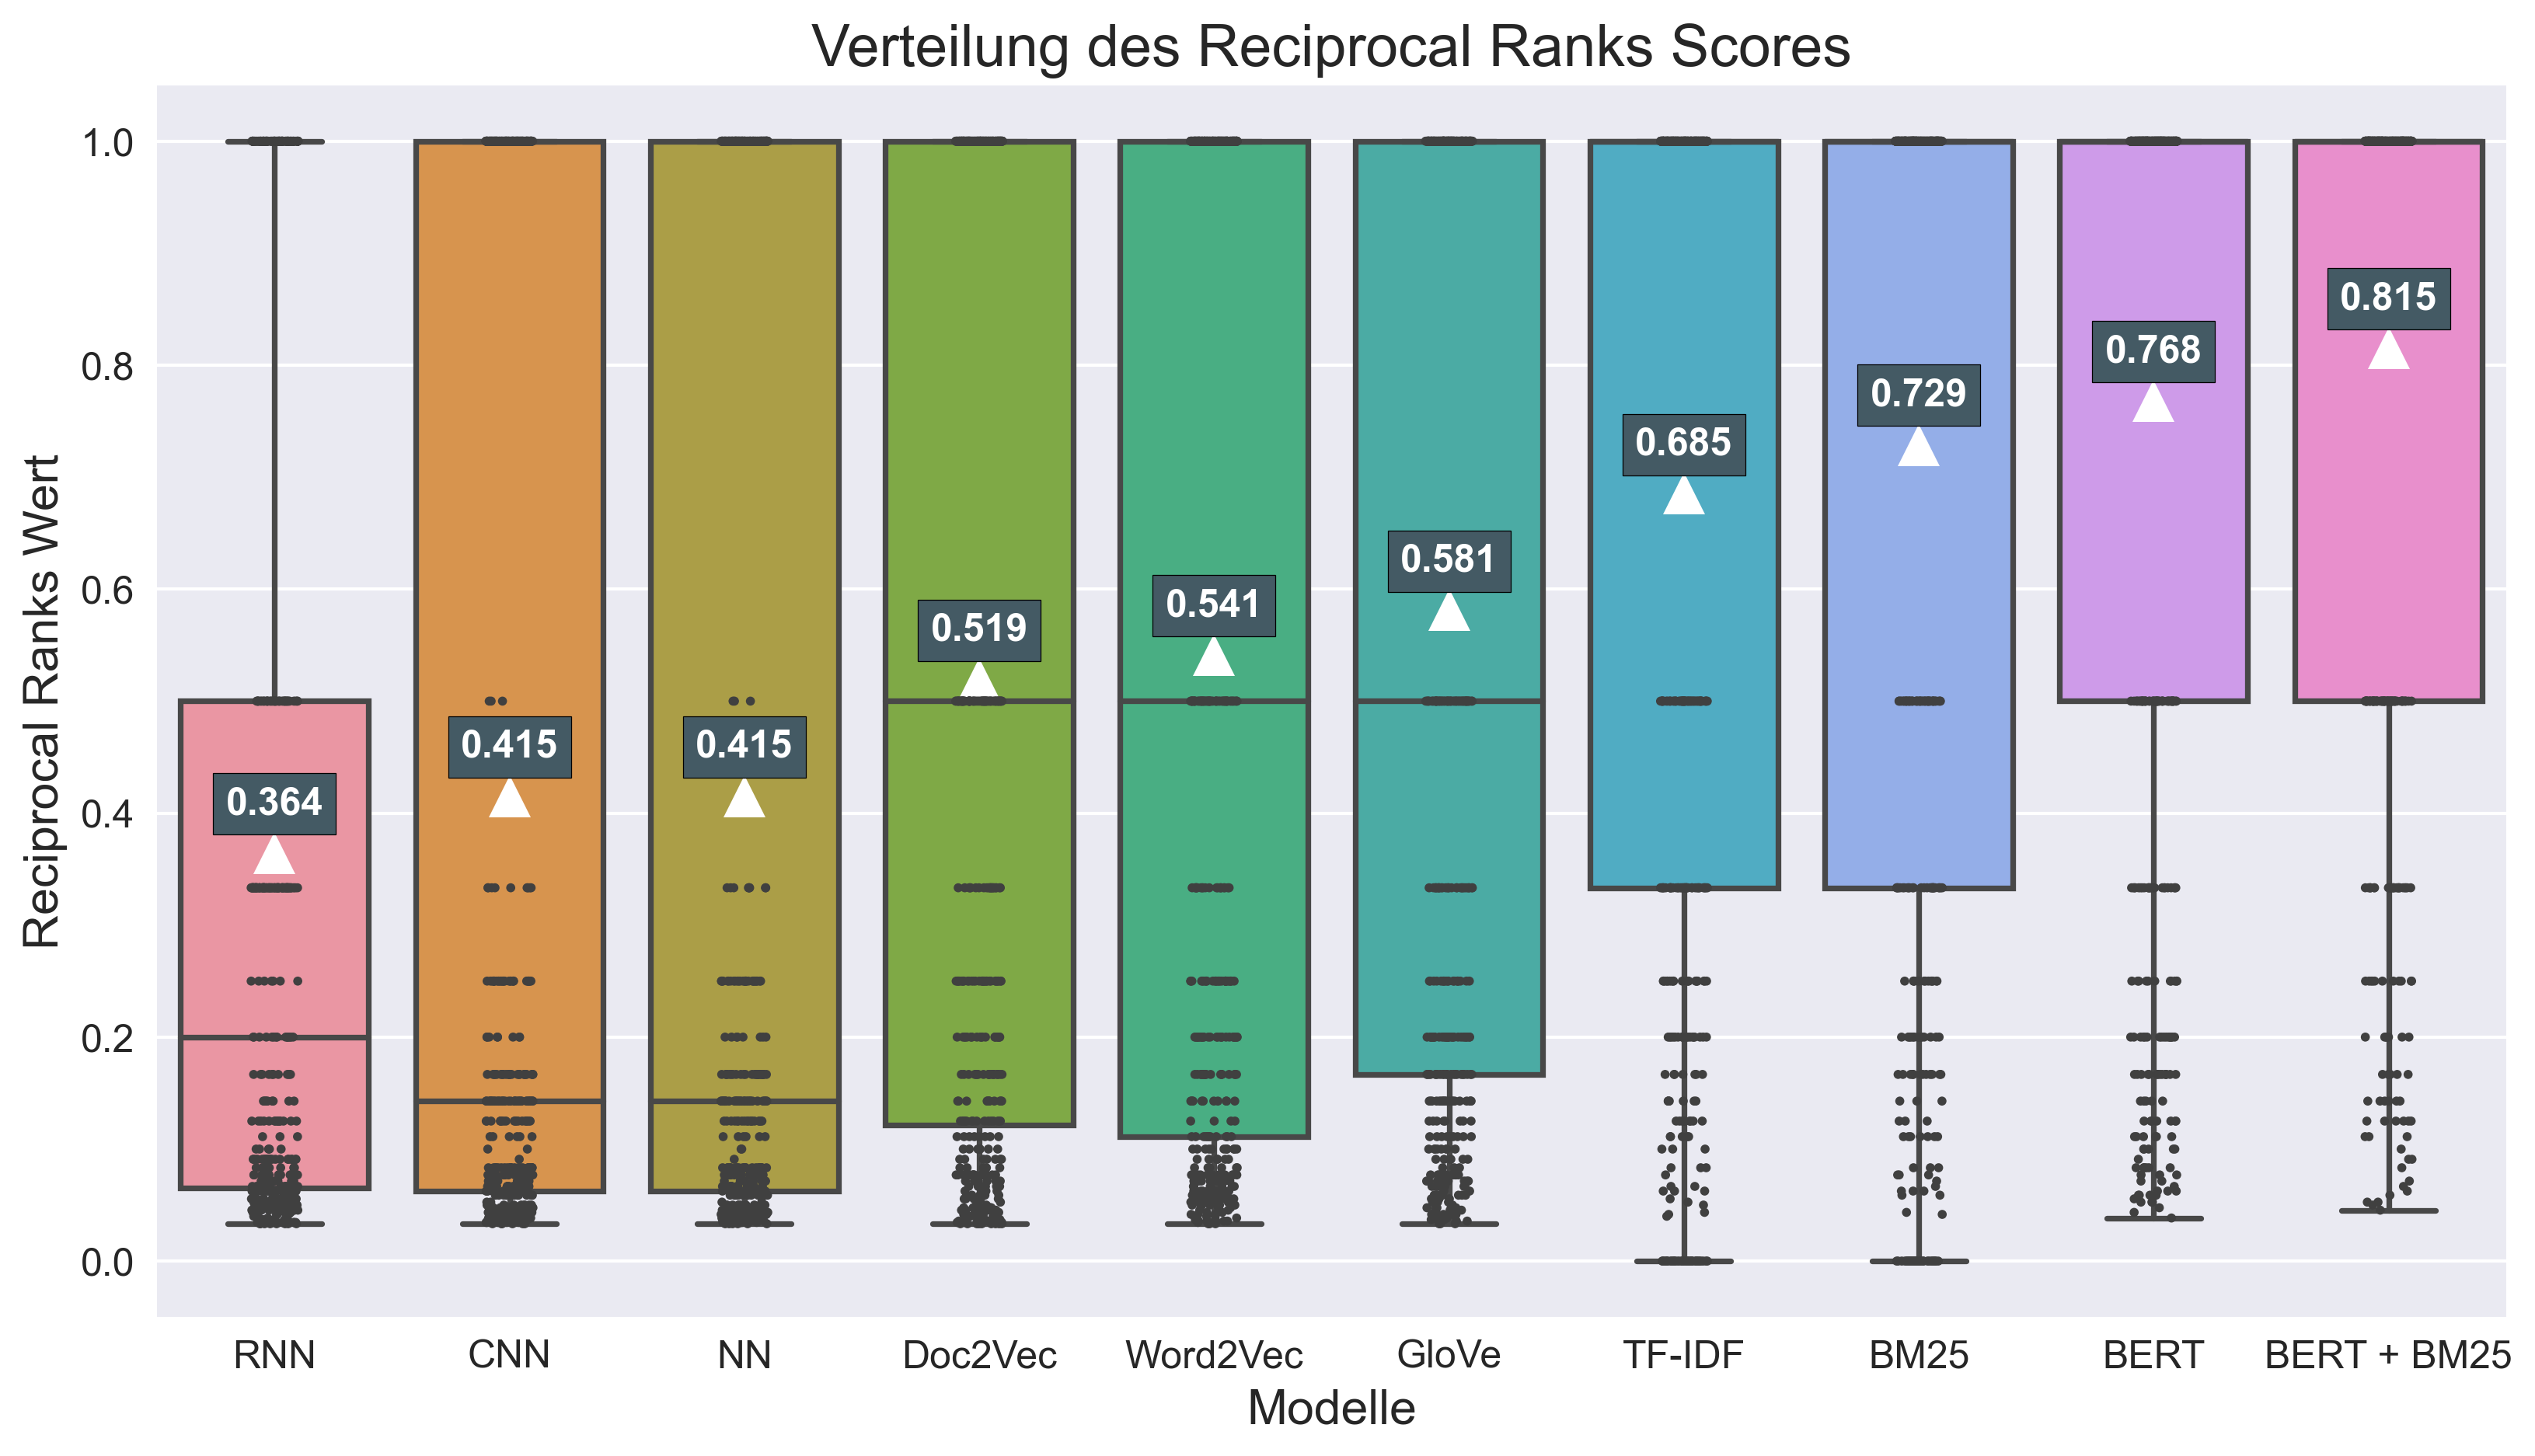

In [6]:
#MRR Ergebnisse plotten
columns = {'Modell' : modell,
          'RR' : mrrScores}
boxesMRR= pd.DataFrame(columns)

fig, ax = plt.subplots(figsize=figsize,dpi=dpi)
box_plot  = sns.boxplot(x="Modell", y="RR", data=boxesMRR, showfliers = False,ax=ax,showmeans=True,
                        meanprops=meanprops)
sns.stripplot(x="Modell", y="RR", data=boxesMRR,ax=ax,color=".25",size=2.8)

medians = np.round(boxesMRR.groupby(['Modell'])['RR'].median(),3)
maps = np.round(boxesMRR.groupby(['Modell'])['RR'].mean(),3)
vertical_offset = boxesMRR['RR'].mean() * 0.06

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,maps[xticksOrder[xtick]] + vertical_offset, maps[xticksOrder[xtick]],
                    horizontalalignment='center',size=12,color='w',weight='semibold',bbox=dict(facecolor='#445A64'))
    
#box_plot.figure.tight_layout()

plt.title('Verteilung des Reciprocal Ranks Scores',fontsize=titleFontSize)
plt.xlabel('Modelle',fontsize=labelFontSize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Reciprocal Ranks Wert',fontsize=labelFontSize)
plt.savefig("Matplots/RR Verteilung.png",bbox_inches='tight')
plt.show()

In [7]:
#Durschnittliche Difference zwischen BERT and BM25 für die Average Precision
bertScores,bm25Scores,combinedScores = [], [], []

for s in allScores:
    for model, score in s.items():
        if model == 'BERT':
            bertScores.append(score['MAP'])
        if model == 'BM25':
            bm25Scores.append(score['MAP'])
        if model == 'BERT + BM25':
            combinedScores.append(score['MAP'])
            

differenz = abs(np.mean(bertScores) - np.mean(bm25Scores))
print(f'Durschnittliche Differenz der beiden Methoden: {differenz}')

#Performance von BERT, wenn BM25 schlecht ist und umgekehrt
bertScoresNew,bm25ScoresNew,combinedScoresNew = [], [], []
countBM, countBERT, countCombined = 0,0,0 

for s in allScores:
    if s['BM25']['MAP'] < 0.2:
        countBM+=1
        bertScoresNew.append(s['BERT']['MAP'])
    
    if s['BERT']['MAP'] < 0.2:
        countBERT+=1
        bm25ScoresNew.append(s['BM25']['MAP'])
    
    if s['BERT + BM25']['MAP'] < 0.2:
        countCombined+=1
        combinedScoresNew.append(s['BM25']['MAP'])
    

print(f'Anteil von BM25 < 0.1 ({countBM / 524}) .')
print(f'Anteil von BERT < 0.1 ({countBERT / 524}) .')
print(f'Anteil von BERT + BM25 < 0.1 ({countCombined / 524}).')

Durschnittliche Differenz der beiden Methoden: 0.04531172460460953
Anteil von BM25 < 0.1 (0.15076335877862596) .
Anteil von BERT < 0.1 (0.11450381679389313) .
Anteil von BERT + BM25 < 0.1 (0.061068702290076333).


0.665


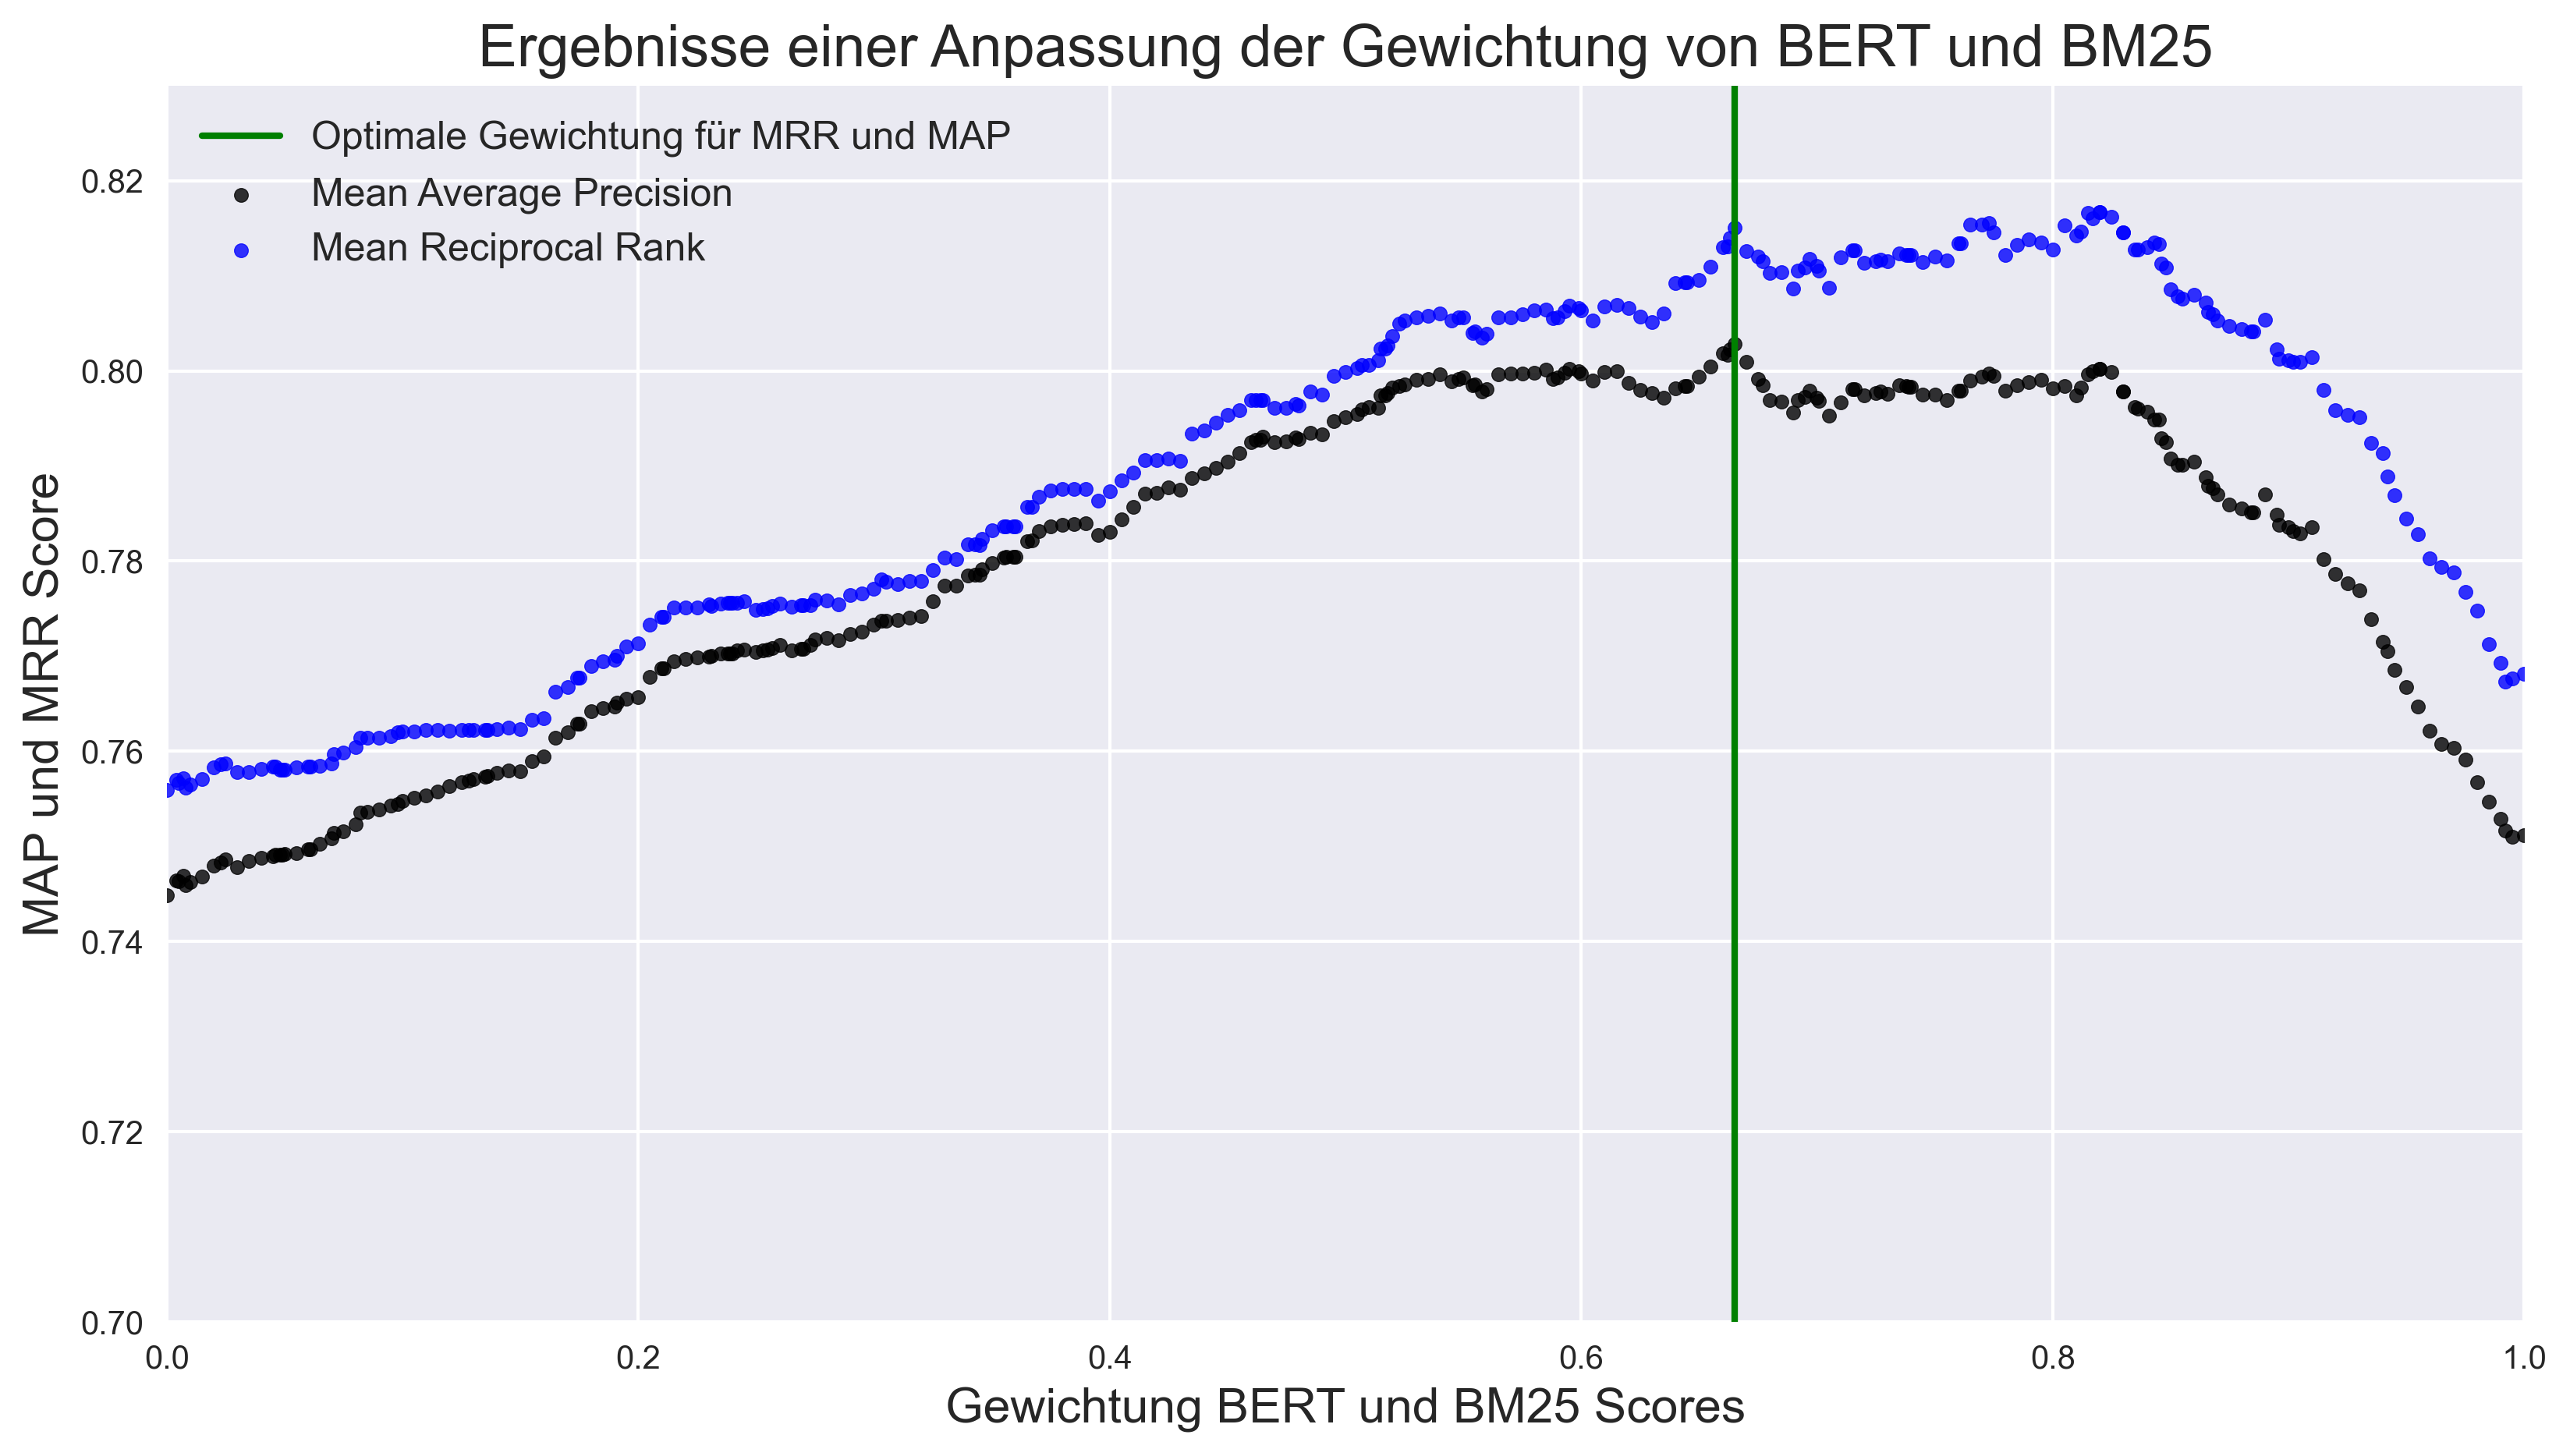

In [8]:
#Optimisierungsresultate plotten

#Bisherige Resultate laden
with open("Data/Visualization/OptimizationResults.json",encoding='utf-8') as file:
    result = json.load(file)

x, yMAP, yMRR = [], [],[]
maxMAP, indexMAP, weightMAP = 0, -1, -1
i = 0
for weight, scores in result.items():
    mapScore,mrrScore = scores[0],scores[1]
    if mapScore > maxMAP:
        maxMAP = mapScore
        indexMAP = i
        weightMAP = weight
    x.append(float(weight))
    yMAP.append(mapScore)
    yMRR.append(mrrScore)
    i +=1

print(weightMAP)
plt.figure(figsize=figsize,dpi=dpi)
plt.axvline(x=float(weightMAP),label='Optimale Gewichtung für MRR und MAP',lw=2,color='green')
plt.scatter(x,yMAP,color='black',label='Mean Average Precision',alpha=0.8,s=18)
plt.scatter(x,yMRR,color='blue',label='Mean Reciprocal Rank',alpha=0.8,s=18)
plt.xlim([0, 1])
plt.ylim([0.7, 0.83]),
plt.xlabel('Gewichtung BERT und BM25 Scores',fontsize=labelFontSize)
plt.ylabel('MAP und MRR Score',fontsize=labelFontSize)
plt.title('Ergebnisse einer Anpassung der Gewichtung von BERT und BM25',fontsize=titleFontSize)
plt.legend(prop={'size':12})
plt.savefig("Matplots/Optimisierungsresultate.png",bbox_inches='tight')
plt.show()

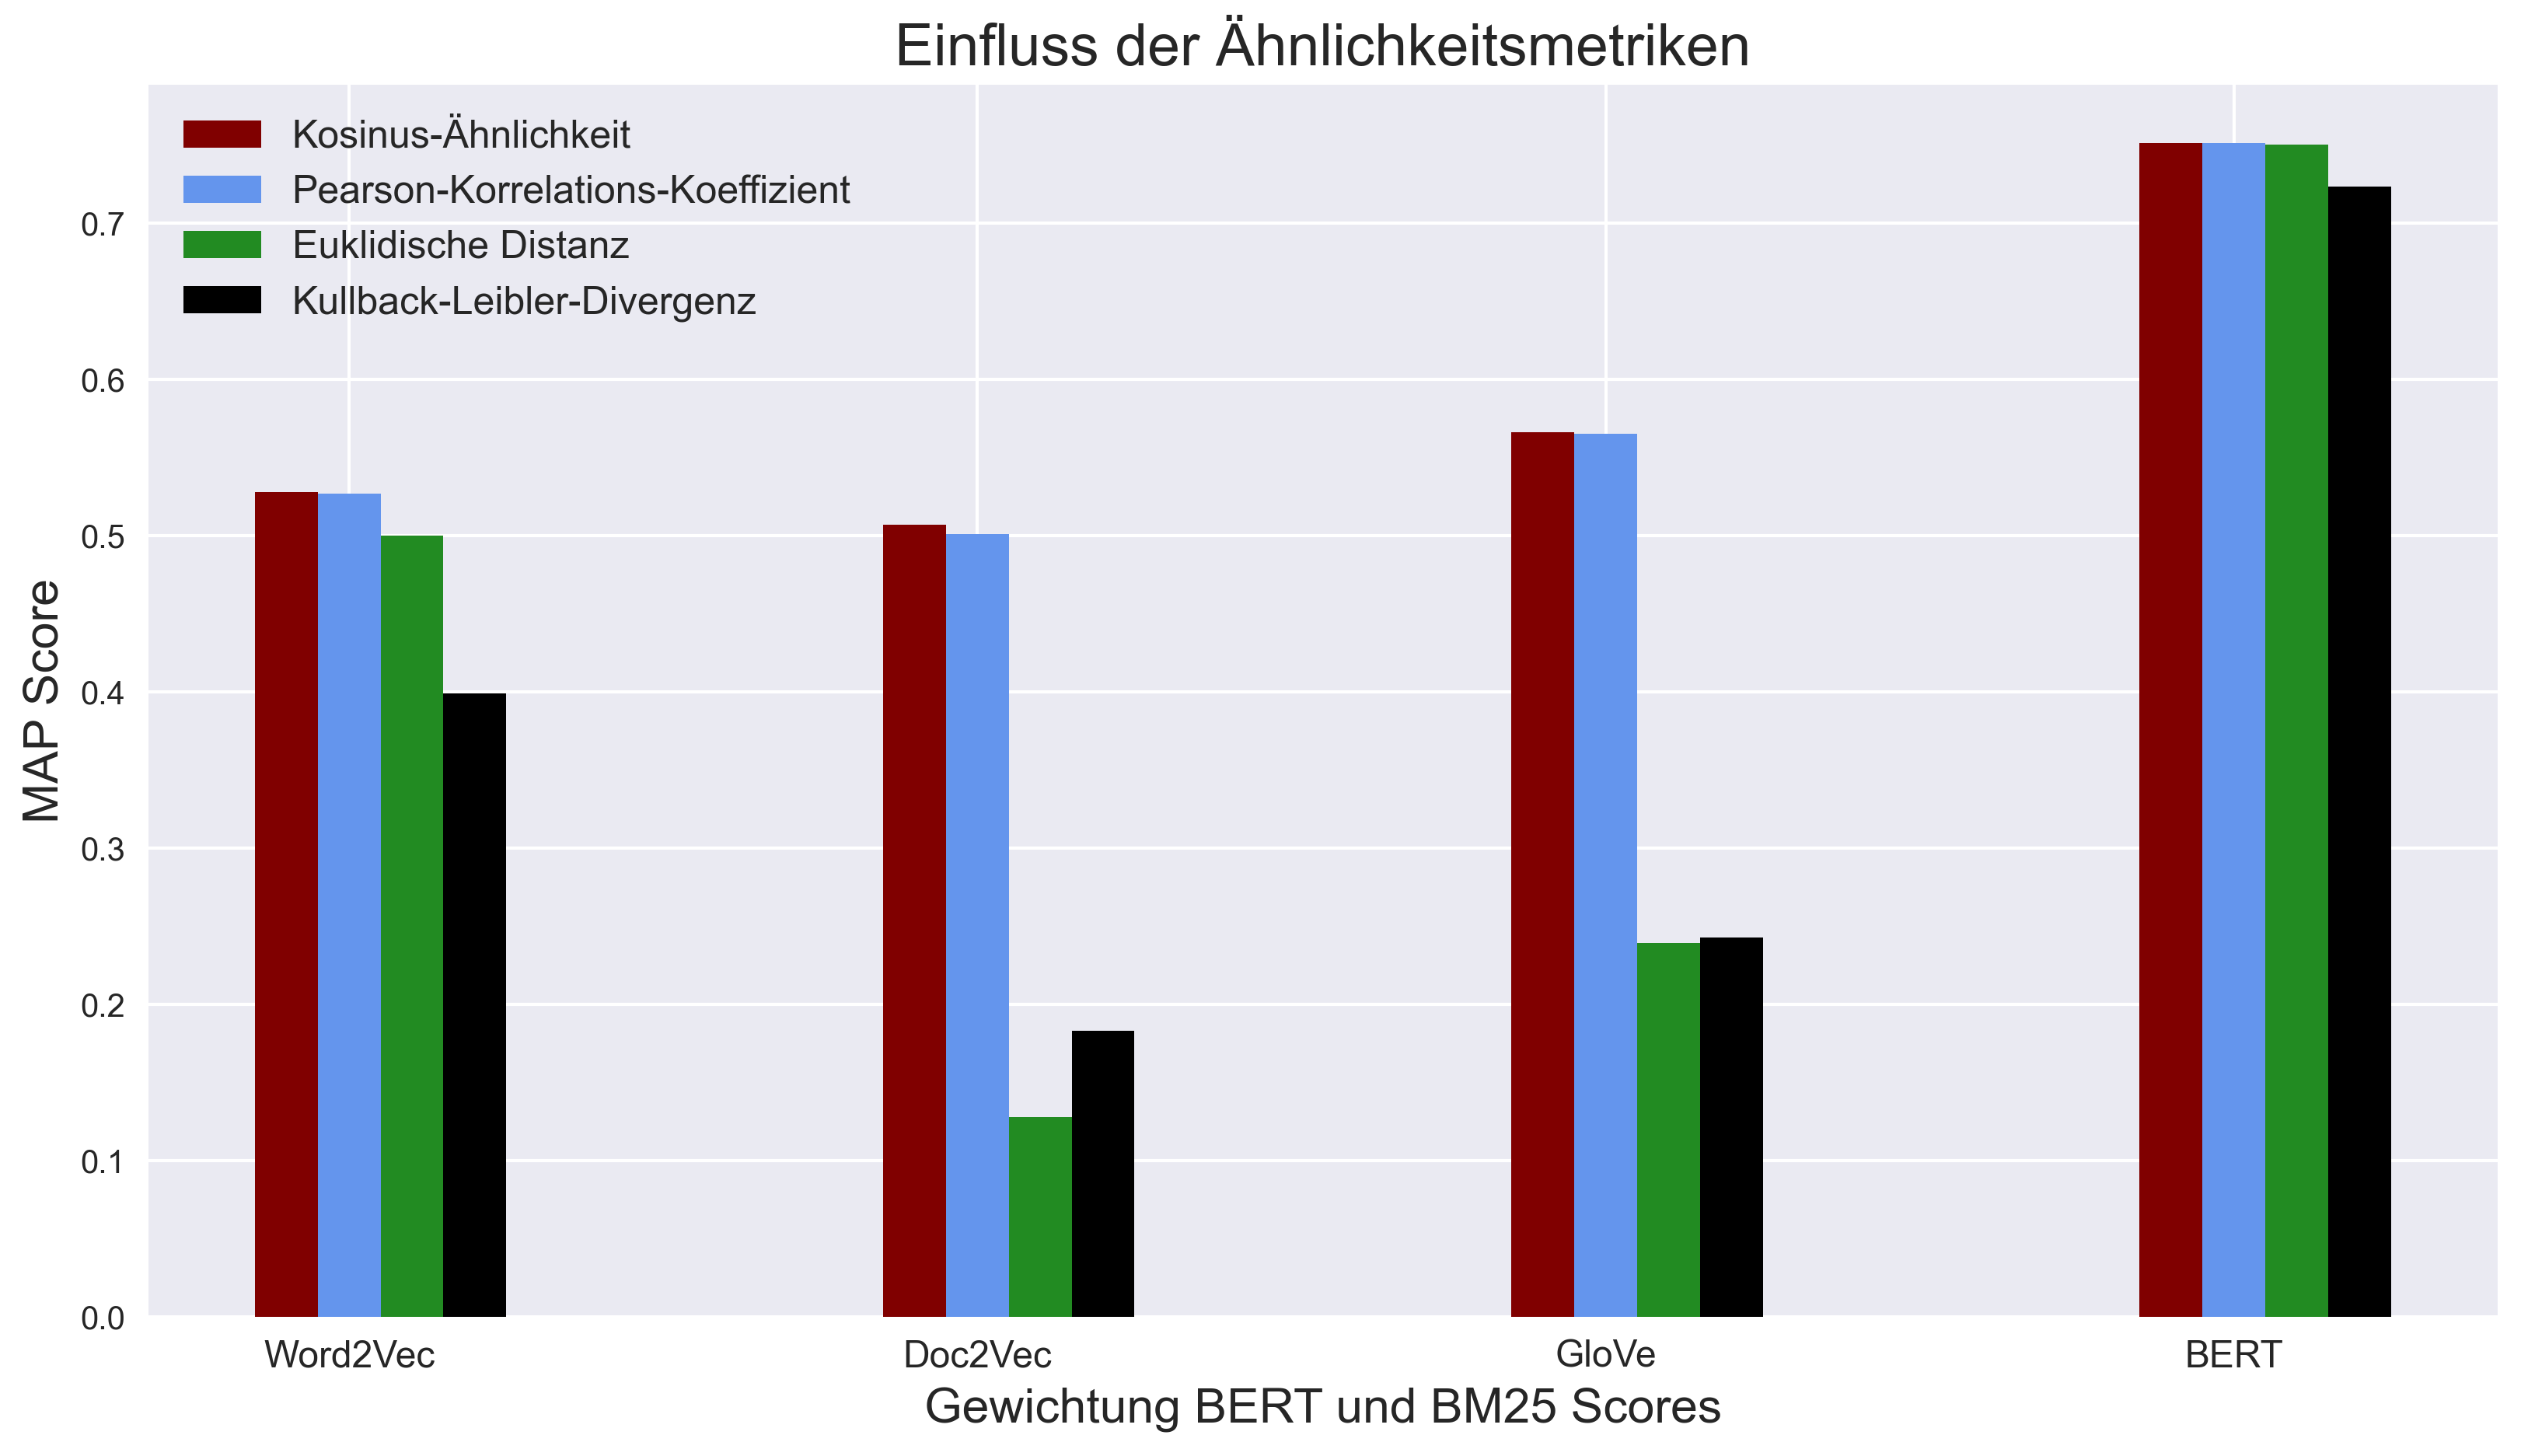

In [9]:
#Visualisieurung der Ergebnisse der Ähnlichkeitsmetriken MAP-Score

#Word2Vec, Doc2Vec, GloVe, BERT
cosineMAP = [0.528,0.507,0.566,0.751]
cosineMRR = [0.541,0.517,0.581,0.768]
                  
pearsonMAP = [0.527,0.501,0.565,0.751]
pearsonMRR = [0.540,0.511,0.581,0.768]

edMAP = [0.500,0.128,0.2395,0.750]
edMRR = [0.518,0.107,0.3277,0.769]     

klMAP = [0.399,0.183,0.243,0.723]
klMRR = [0.420,0.267,0.33,0.740]

labels = ['Word2Vec', 'Doc2Vec','GloVe','BERT']
width = 0.1

r1 = np.arange(len(labels))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]

plt.figure(figsize=figsize,dpi=dpi)
plt.bar(r1, cosineMAP, width, label='Kosinus-Ähnlichkeit',color='maroon')
plt.bar(r2, pearsonMAP, width, label='Pearson-Korrelations-Koeffizient',color='cornflowerblue')
plt.bar(r3, edMAP, width, label='Euklidische Distanz',color='forestgreen')
plt.bar(r4, klMAP, width, label='Kullback-Leibler-Divergenz',color='black')
plt.xticks([r + width for r in range(len(cosineMAP))],labels,fontsize=11.5)
plt.xlabel('Gewichtung BERT und BM25 Scores',fontsize=labelFontSize)
plt.ylabel('MAP Score',fontsize=labelFontSize)
plt.title('Einfluss der Ähnlichkeitsmetriken',fontsize=titleFontSize)
plt.legend(prop={'size':12})
plt.savefig("Matplots/ÄhnlichkeitsmetrikenMAP.png",bbox_inches='tight')
plt.show()

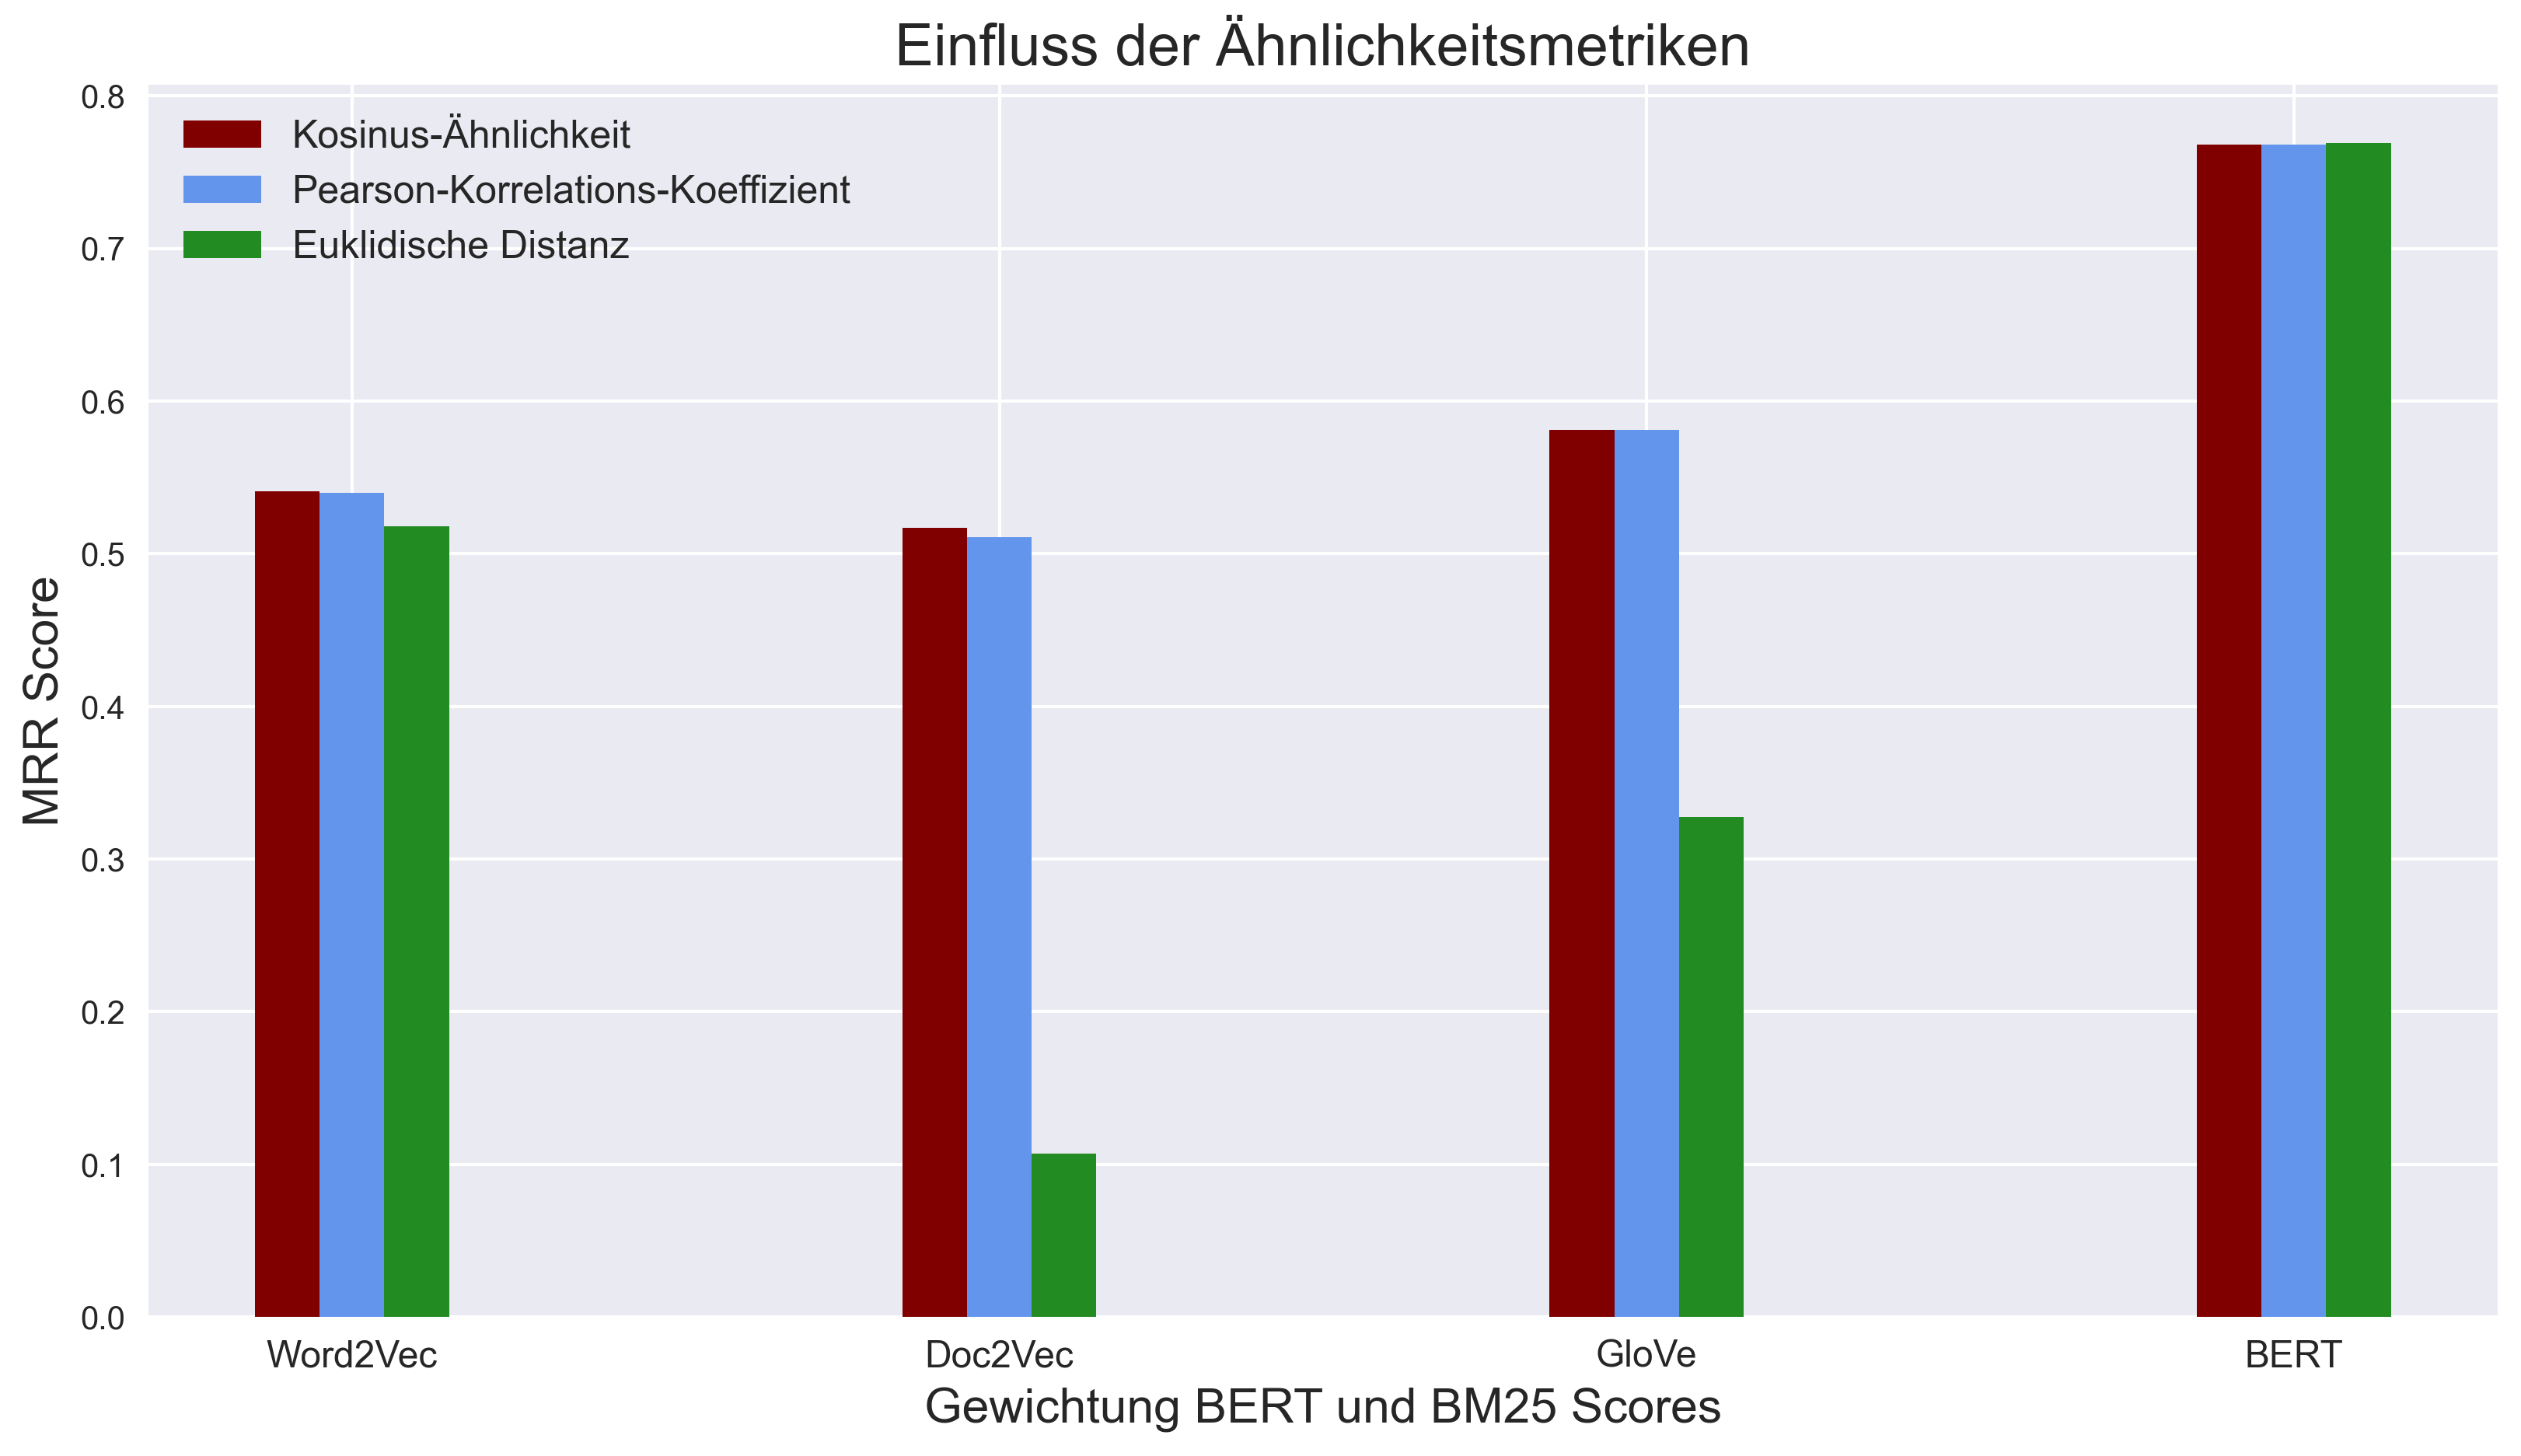

In [10]:
#Visualisieurung der Ergebnisse der Ähnlichkeitsmetriken MAP-Score

plt.figure(figsize=figsize,dpi=dpi)
plt.bar(r1, cosineMRR, width, label='Kosinus-Ähnlichkeit',color='maroon')
plt.bar(r2, pearsonMRR, width, label='Pearson-Korrelations-Koeffizient',color='cornflowerblue')
plt.bar(r3, edMRR, width, label='Euklidische Distanz',color='forestgreen')
plt.xticks([r + width for r in range(len(cosineMAP))],labels,fontsize=11.5)
plt.xlabel('Gewichtung BERT und BM25 Scores',fontsize=labelFontSize)
plt.ylabel('MRR Score',fontsize=labelFontSize)
plt.title('Einfluss der Ähnlichkeitsmetriken',fontsize=titleFontSize)
plt.legend(prop={'size':12})
plt.savefig("Matplots/ÄhnlichkeitsmetrikenMRR.png",bbox_inches='tight')
plt.show()

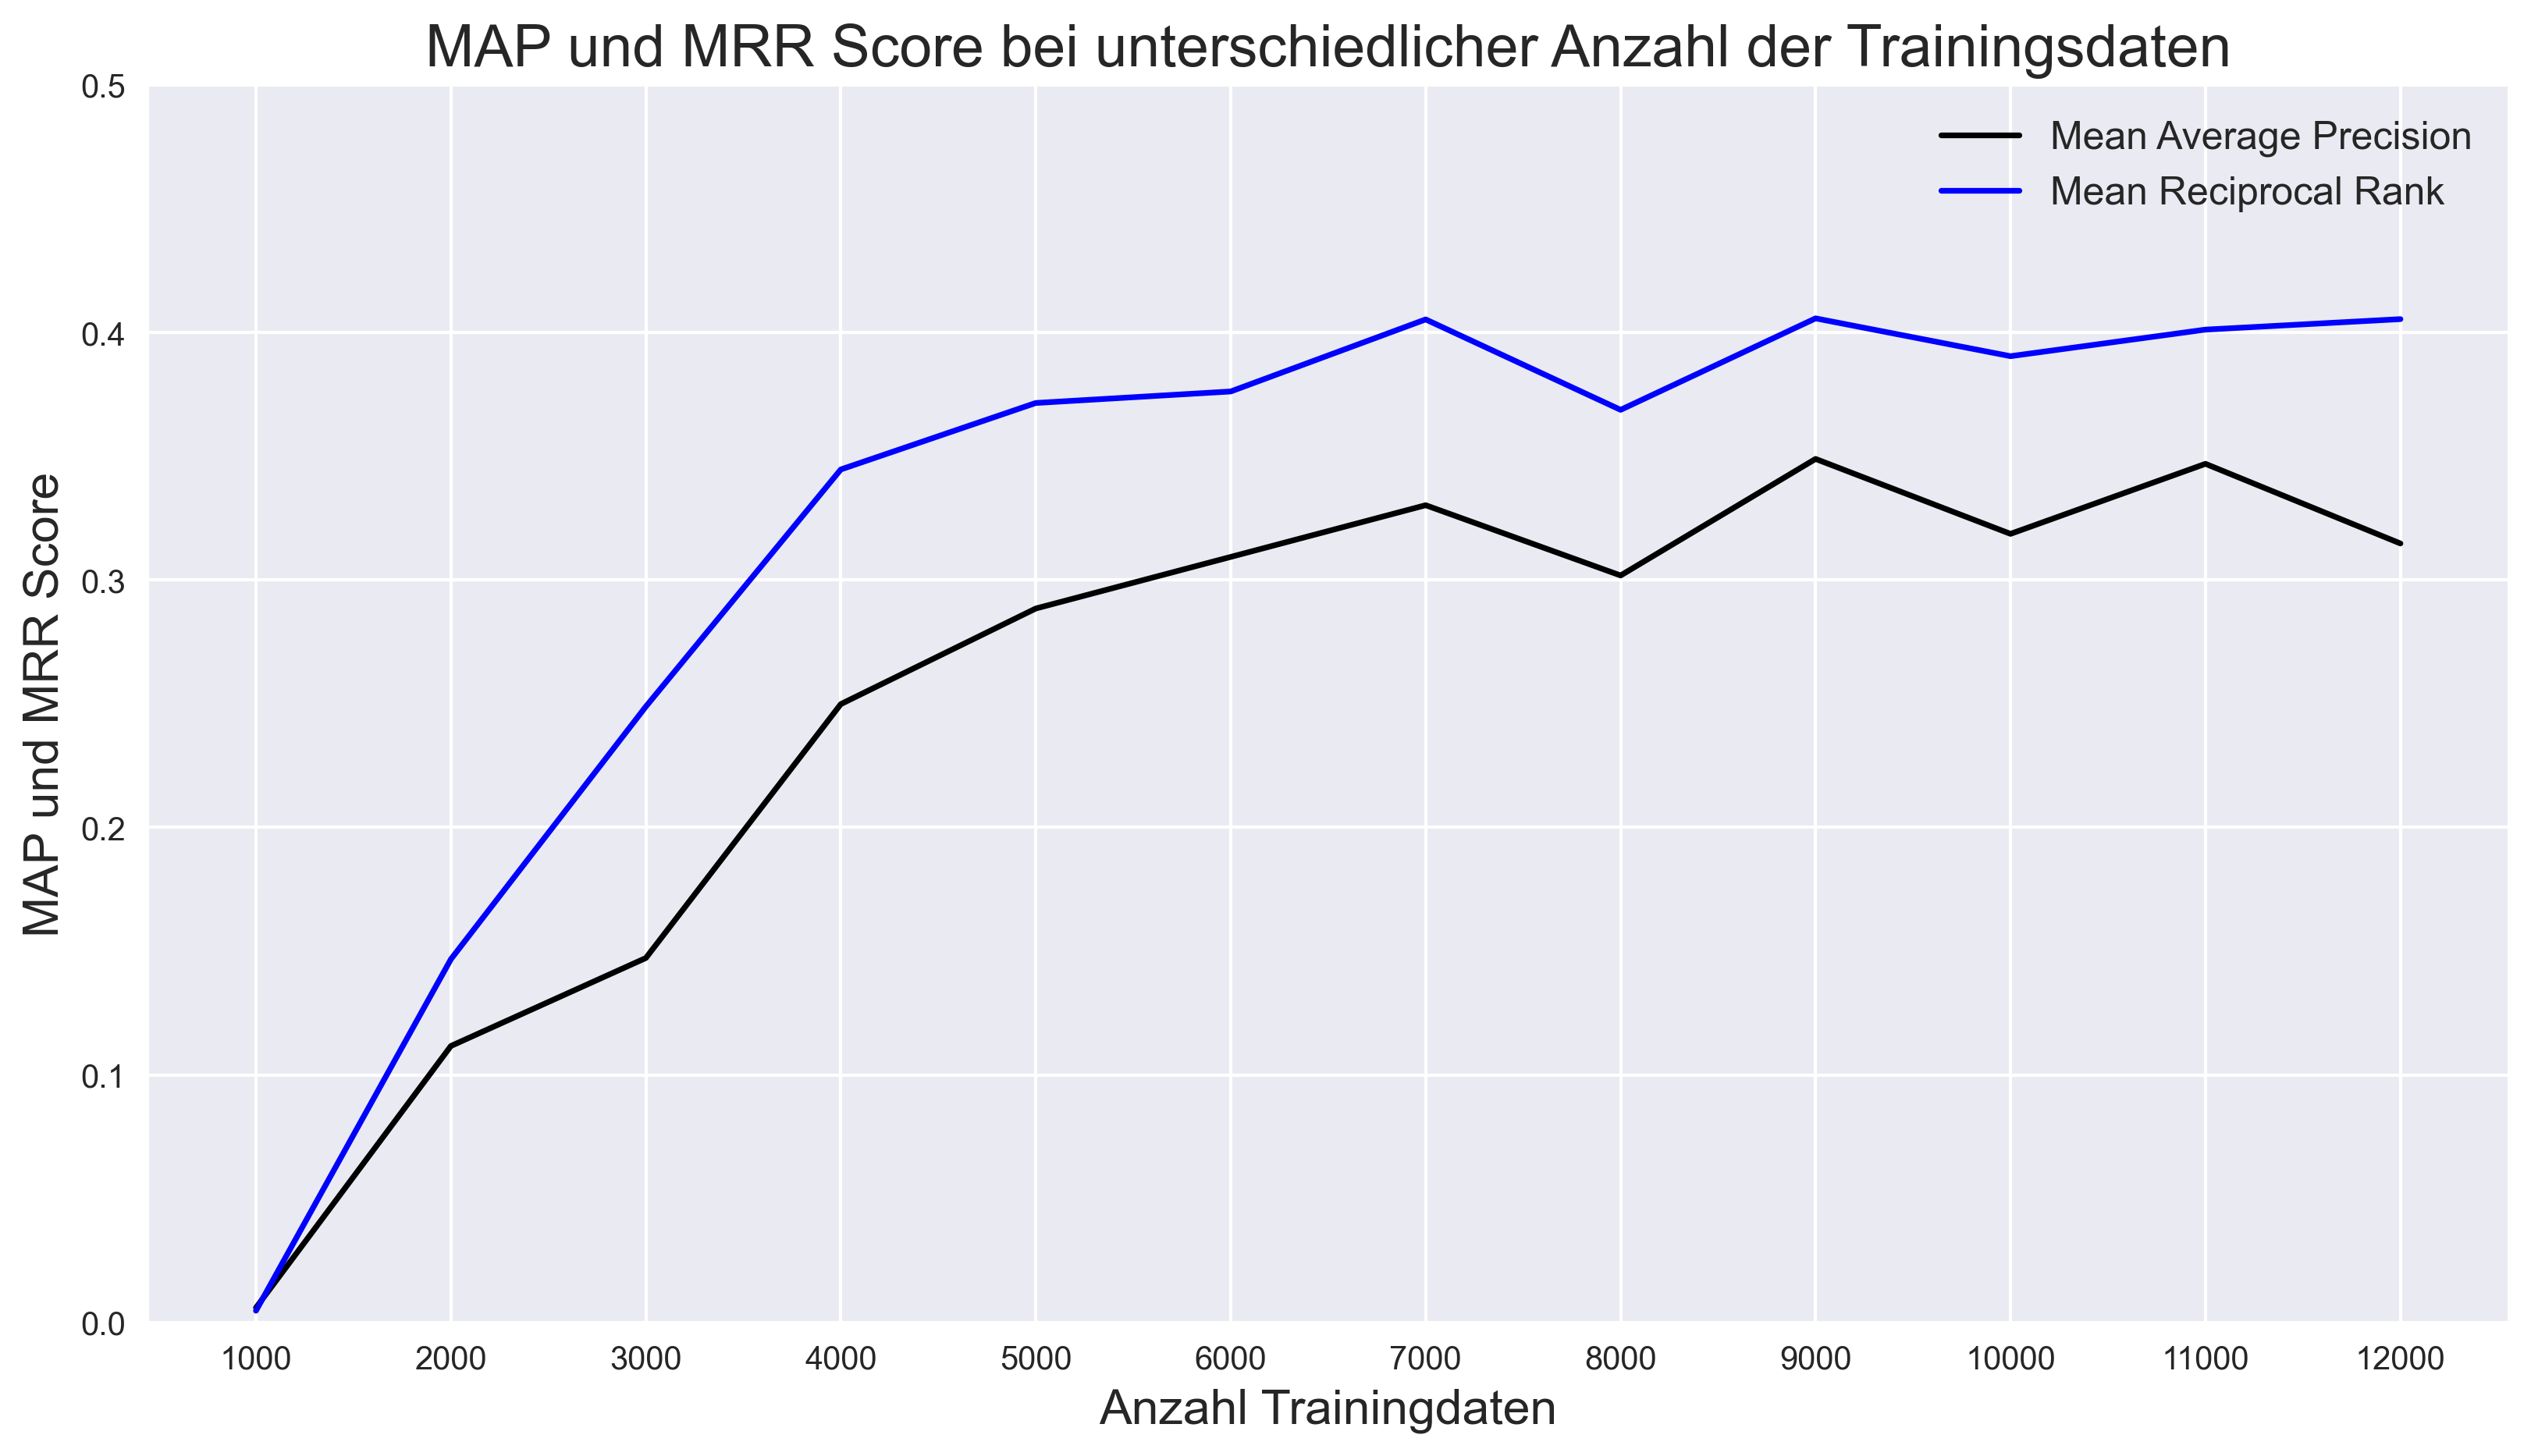

In [11]:
#Entwicklung der Ergebnisse des Neuronalen Netzes mit der Anzahl der Daten

with open("Data/Visualization/MAPDev.json",encoding='utf-8') as file:
    map_mrr_Dev = json.load(file)
    
x = list(map_mrr_Dev.keys())
yMAP, yMRR = [],[]

for scores in map_mrr_Dev.values():
    yMAP.append(scores['MAP'])
    yMRR.append(scores['MRR'])

x.reverse()
yMAP.reverse()
yMRR.reverse()
plt.figure(figsize=figsize,dpi=dpi)
plt.plot(x,yMAP, label='Mean Average Precision',color='black')
plt.plot(x,yMRR, label='Mean Reciprocal Rank',color='blue')
plt.ylim([0, 0.5])
plt.xlabel('Anzahl Trainingdaten',fontsize=labelFontSize)
plt.ylabel('MAP und MRR Score',fontsize=labelFontSize)
plt.title('MAP und MRR Score bei unterschiedlicher Anzahl der Trainingsdaten',fontsize=titleFontSize)
plt.legend(prop={'size':12})
plt.savefig("Matplots/TrainingsanzahlNN.png",bbox_inches='tight')
plt.show()

Quantille: 0.2966218651297838
FN: 0.5, FP: 0.0394845644983462


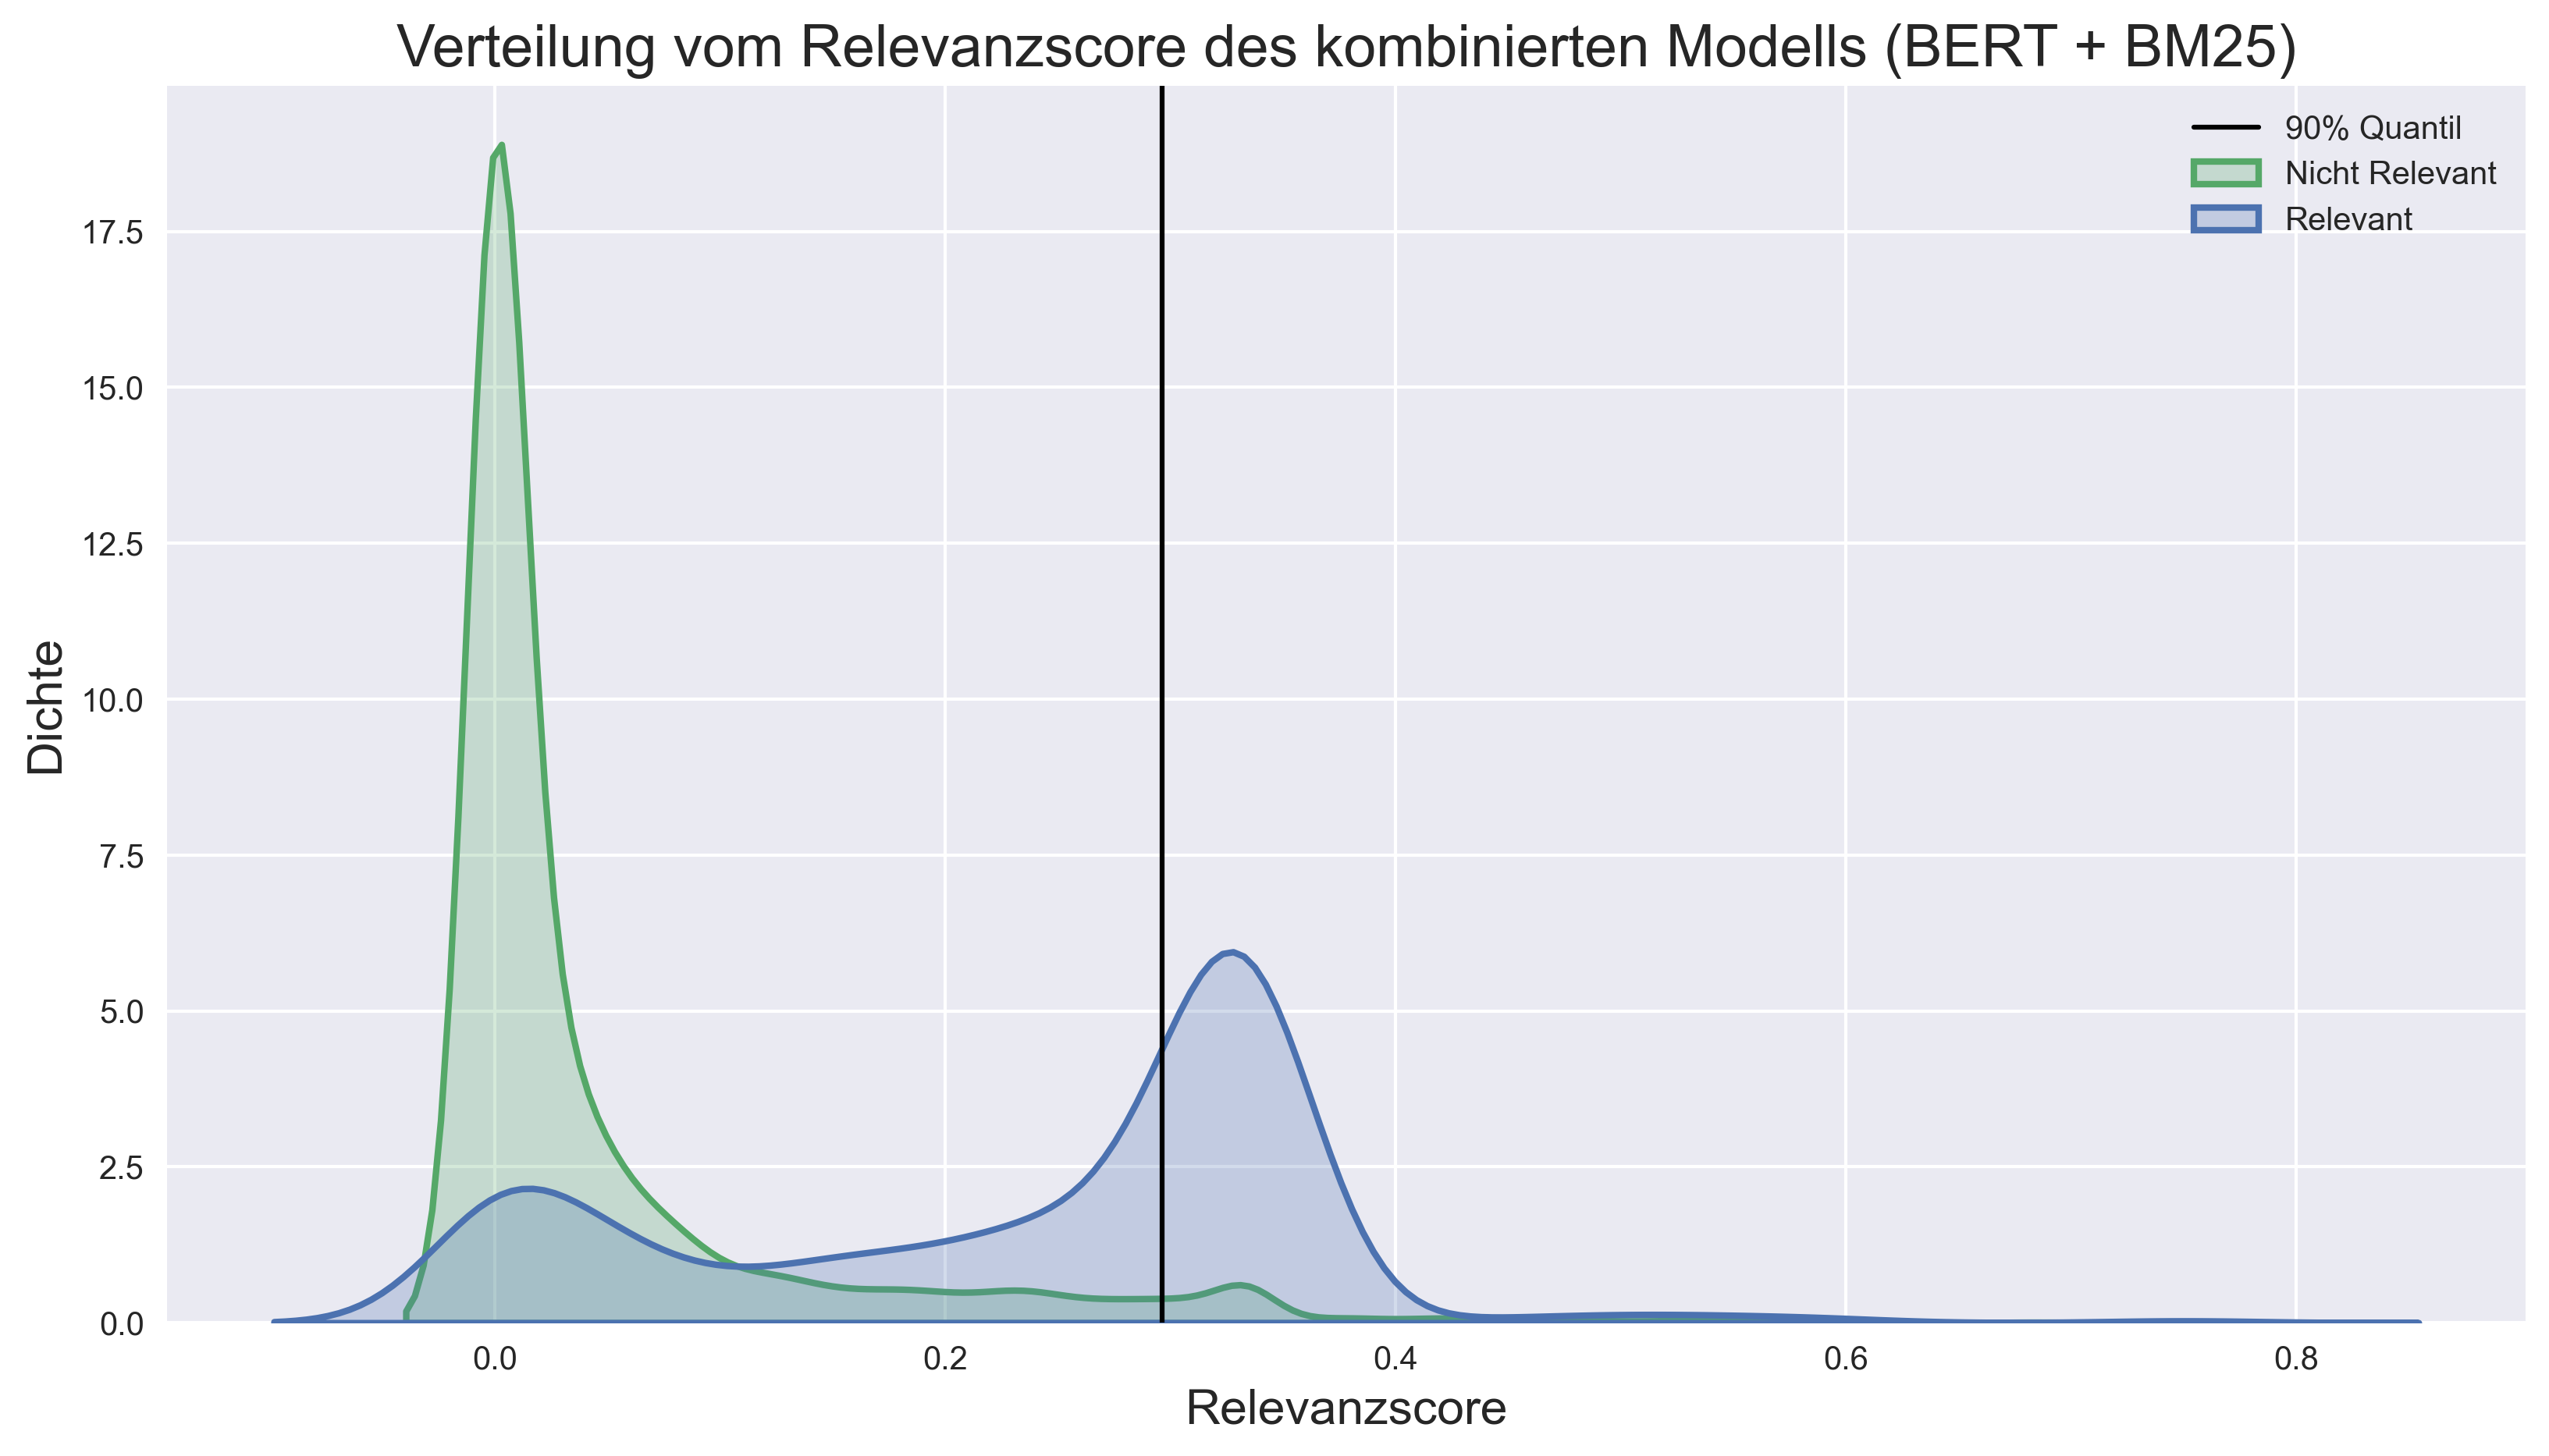

In [12]:
# Distribution der Relevanzscores von BM25 und BERT plotten
with open("Data/Visualization/CombinedScoreDistribution.json",encoding='utf-8') as file:
    combinedDist = json.load(file)

rScores,nrScores = combinedDist['Relevant'], combinedDist['Non-Relevant']
relevance,scores = [],[]
for key, value in combinedDist.items():
    for i in value:
        scores.append(i)
        relevance.append(key)
                
distColumns = {'Relevanz' : relevance, 'Score' : scores}
dfRelevanceDist = pd.DataFrame(distColumns)
val = 0.5
quantile = np.quantile(rScores, val)
fpCount = sum(x > quantile for x in nrScores)
fnCount = sum(x <= quantile for x in rScores)
print(f'Quantille: {quantile}')
print(f'FN: {val}, FP: {fpCount/ len(nrScores)}')


fig, ax1 = plt.subplots(figsize=figsize, dpi=dpi)
sns.kdeplot(data=dfRelevanceDist,common_norm=False,x="Score", legend=True,hue='Relevanz',fill=True, linewidth=2)
plt.axvline(x=quantile, label='90% Quantil',lw=1.5,color='black')
ax1.set_title('Verteilung vom Relevanzscore des kombinierten Modells (BERT + BM25)',fontsize=titleFontSize)
ax1.set_xlabel('Relevanzscore',fontsize=labelFontSize)
ax1.set_ylabel('Dichte',fontsize=labelFontSize)
plt.legend(loc='best', labels=['90% Quantil','Nicht Relevant','Relevant'])
plt.savefig("Matplots/CombinedDistribution.png",bbox_inches='tight')
plt.show()

Quantille: 1.5979346367584648
FN: 0.3, FP: 0.1573180815876516


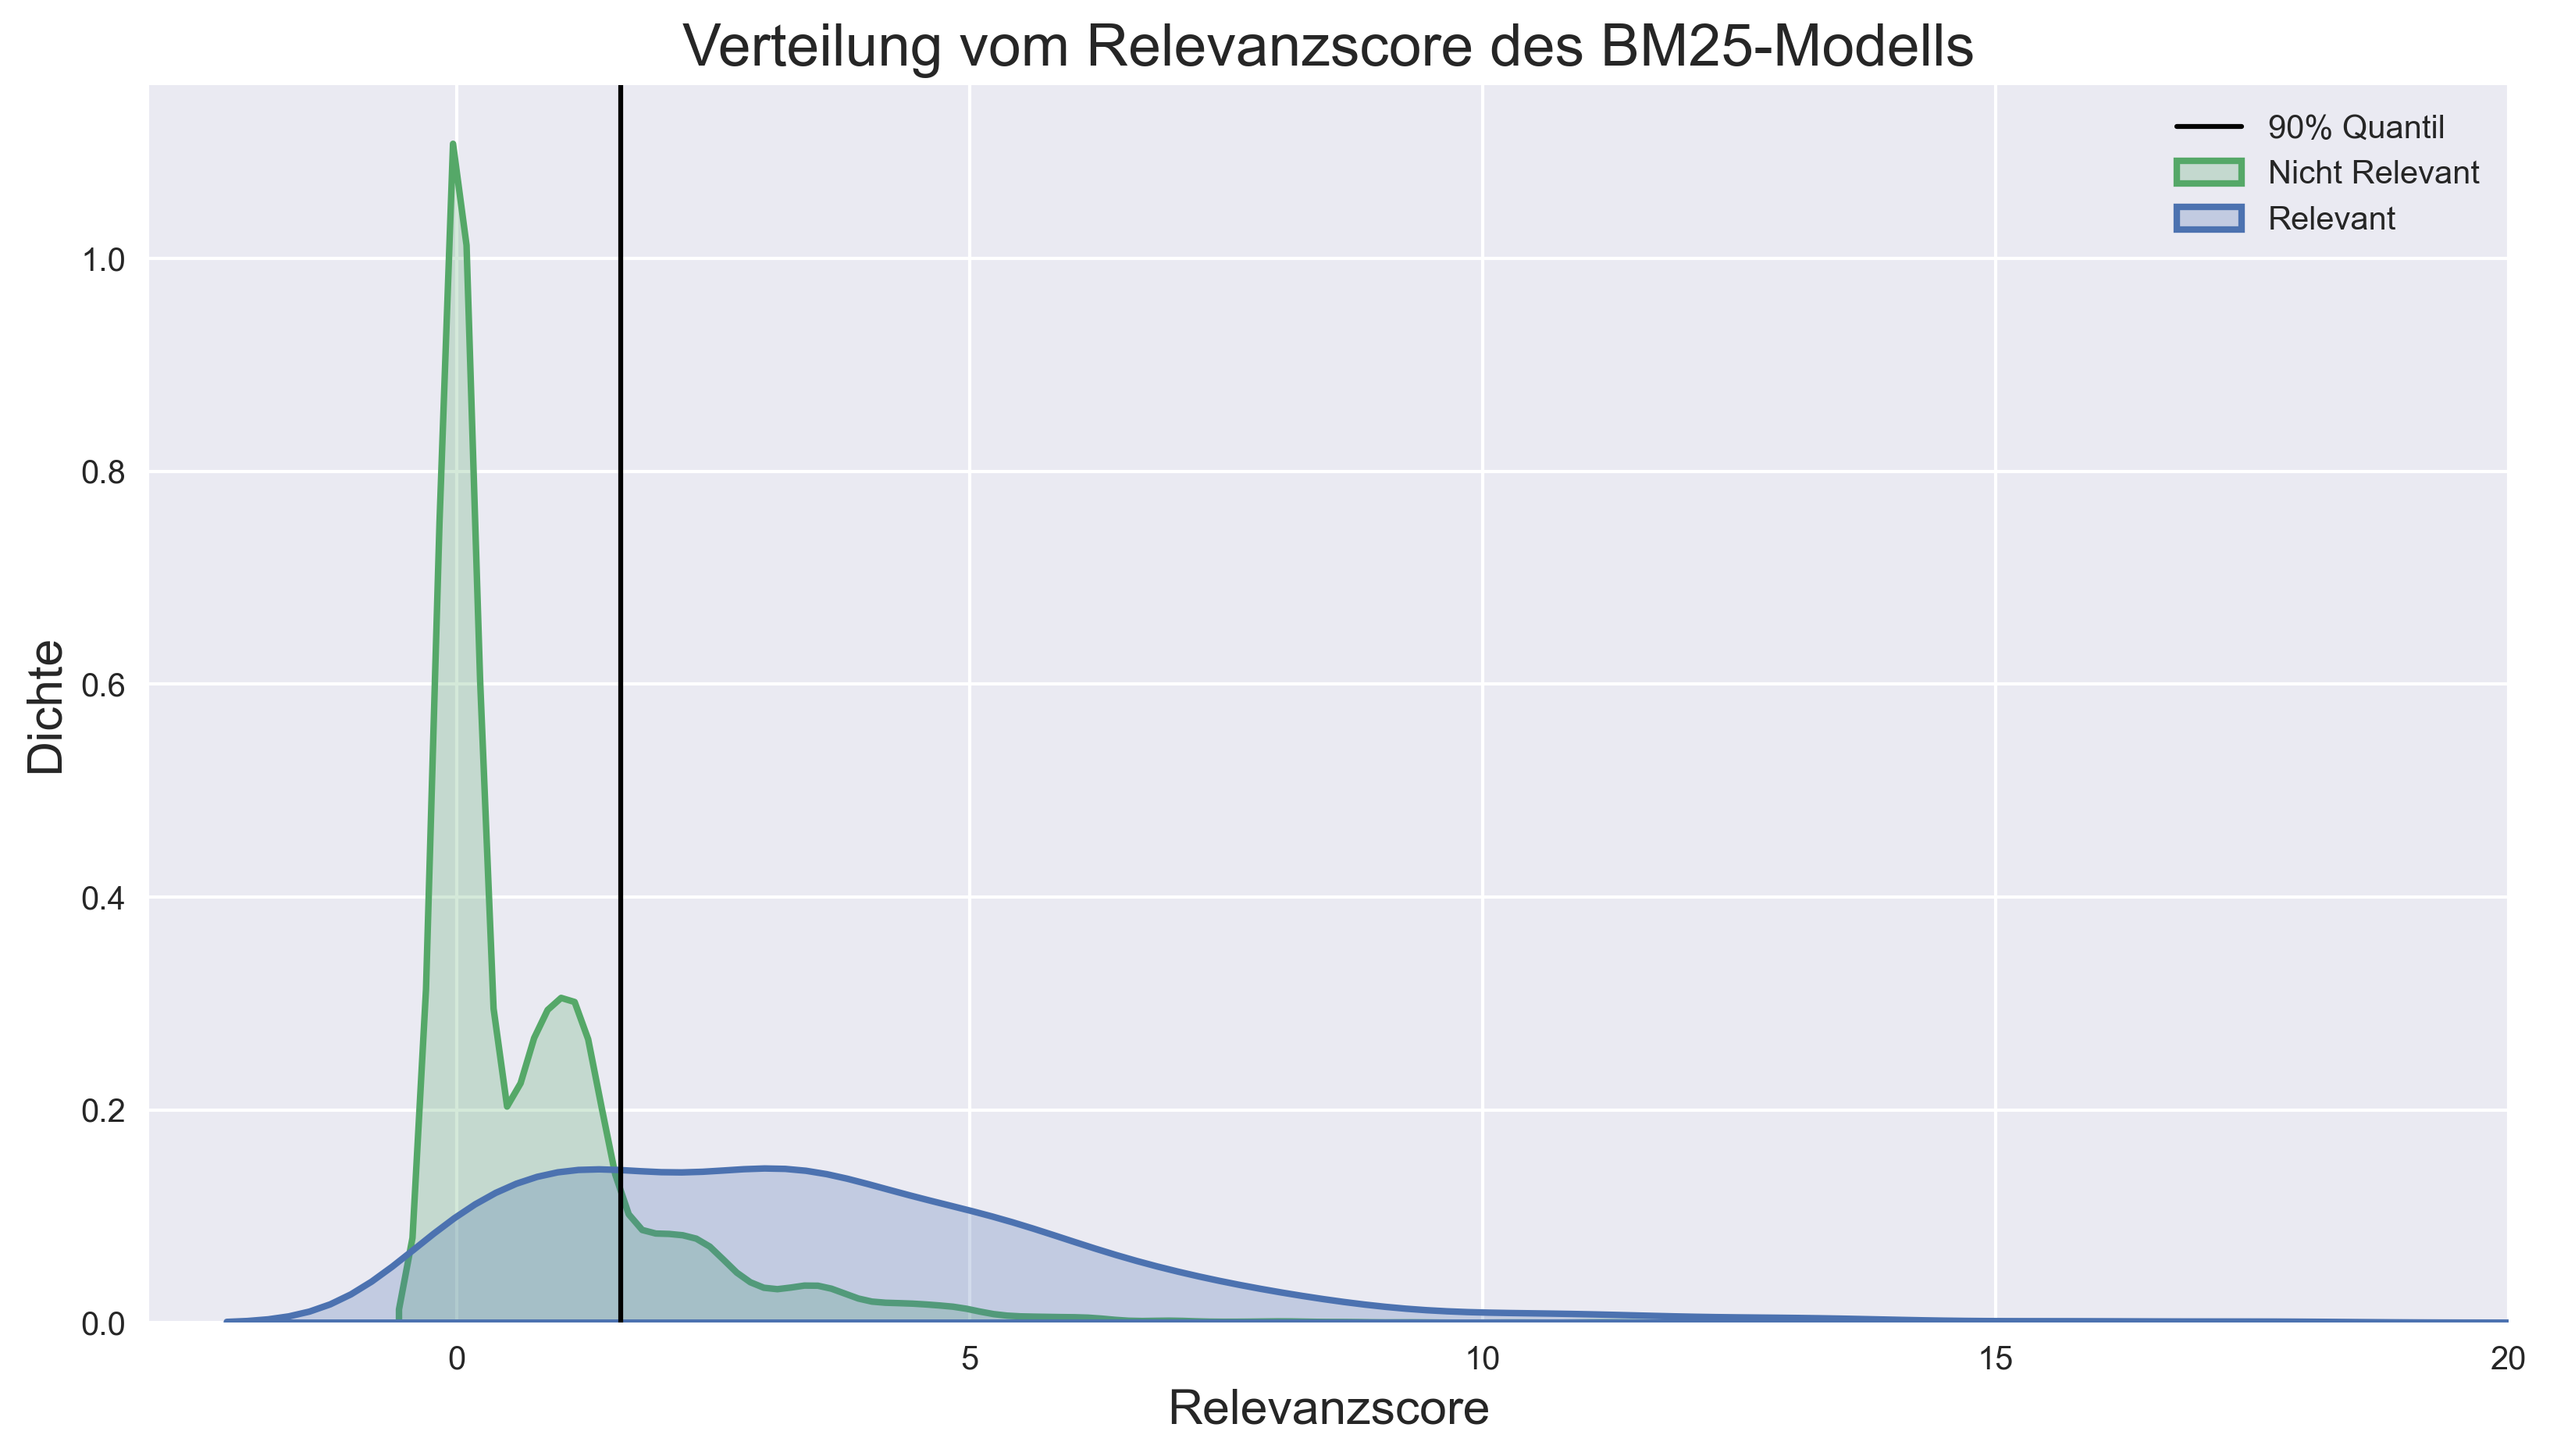

In [13]:
# Distribution der Relevanzscores von BM25 und BERT plotten
with open("Data/Visualization/BM25ScoreDistribution.json",encoding='utf-8') as file:
    bm25Dist = json.load(file)

rScores,nrScores = bm25Dist['Relevant'], bm25Dist['Non-Relevant']
relevance,scores = [],[]
for key, value in bm25Dist.items():
    for i in value:
        scores.append(i)
        relevance.append(key)
                
distColumns = {'Relevanz' : relevance, 'Score' : scores}
dfRelevanceDist = pd.DataFrame(distColumns)
val = 0.3
quantile = np.quantile(rScores, val)
fpCount = sum(x > quantile for x in nrScores)
fnCount = sum(x <= quantile for x in rScores)
print(f'Quantille: {quantile}')
print(f'FN: {val}, FP: {fpCount/ len(nrScores)}')


fig, ax1 = plt.subplots(figsize=figsize, dpi=dpi)
sns.kdeplot(data=dfRelevanceDist,common_norm=False,x="Score", legend=True,hue='Relevanz',fill=True, linewidth=2)
#sns.histplot(data=rScores,stat='probability',cumulative=False,bins=30,kde=True,label='BERT Relevanzerteilung')
plt.axvline(x=quantile, label='90% Quantil',lw=1.5,color='black')
ax1.set_title('Verteilung vom Relevanzscore des BM25-Modells',fontsize=titleFontSize)
ax1.set_xlim([-3,20])
ax1.set_xlabel('Relevanzscore',fontsize=labelFontSize)
ax1.set_ylabel('Dichte',fontsize=labelFontSize)
plt.legend(loc='best', labels=['90% Quantil','Nicht Relevant','Relevant'])
plt.savefig("Matplots/BM25Distribution.png",bbox_inches='tight')
plt.show()

Quantille: 0.5651705622673036
FN: 0.3, FP: 0.16572491730981256
Quantilenwert: (0.3, 0.5651705622673036), Anteil nicht relevant: 0.16572491730981256


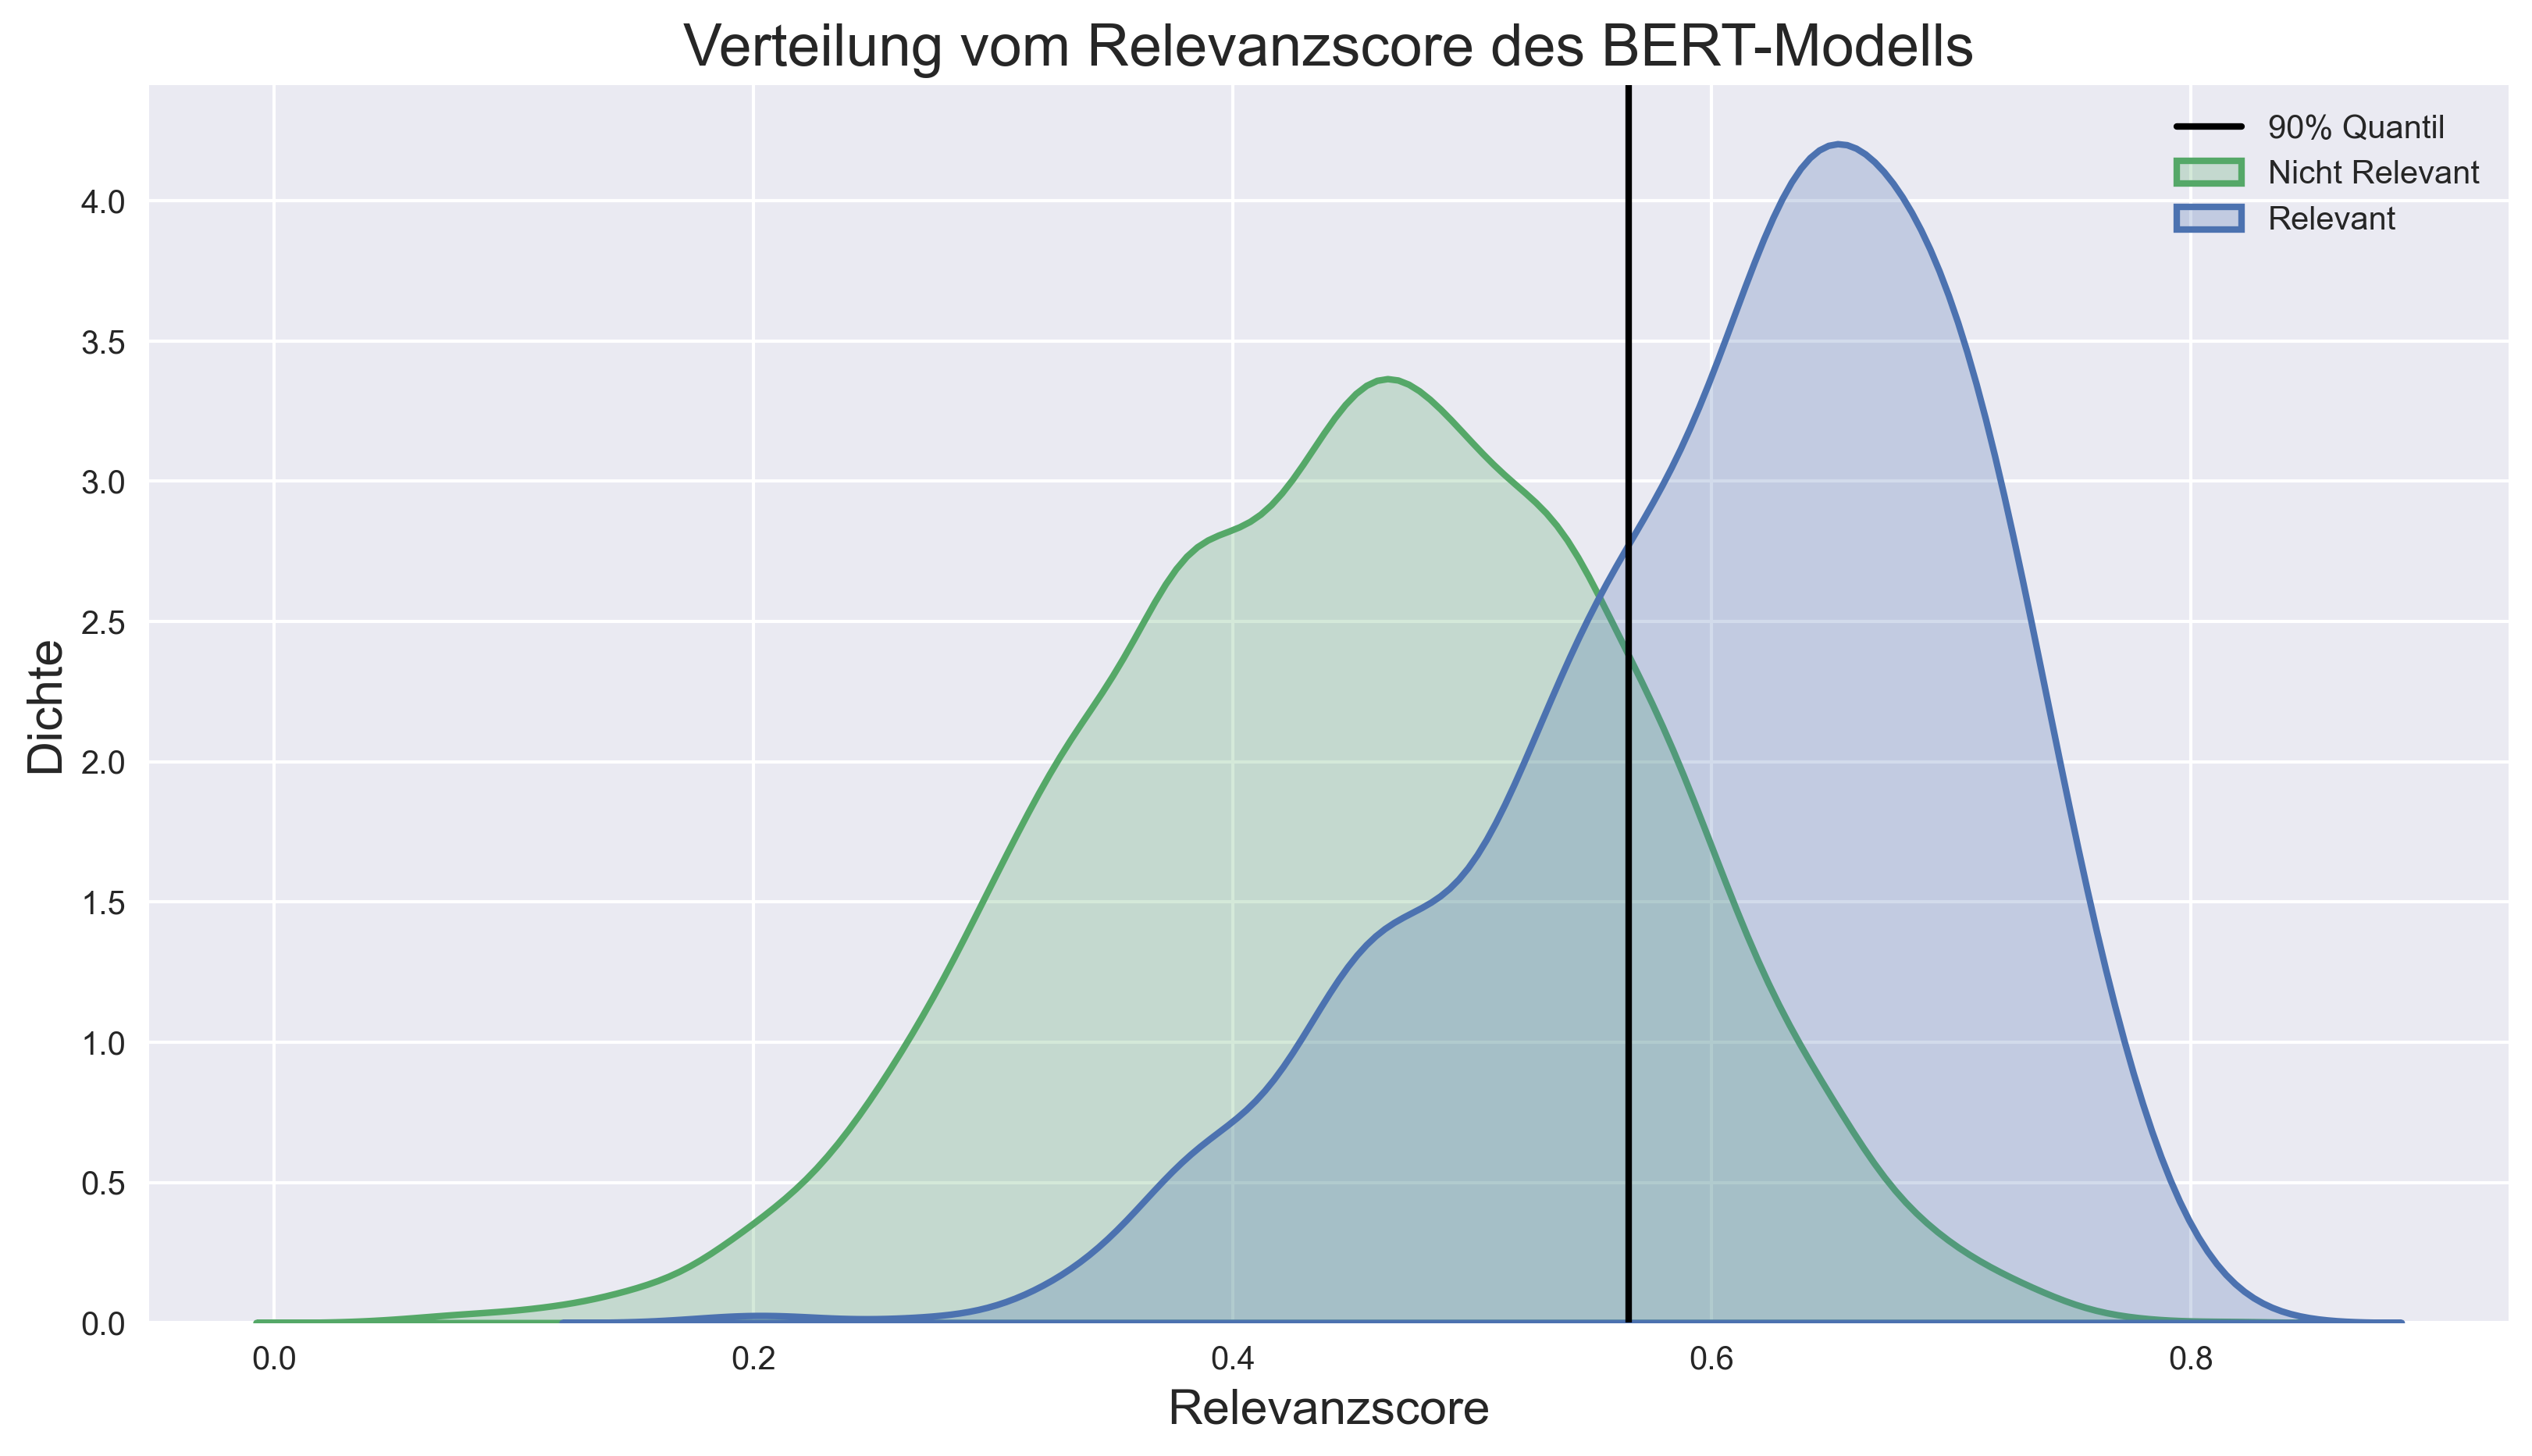

In [14]:
# Distribution der Relevanzscores von BM25 und BERT plotten
with open("Data/Visualization/BERTScoreDistribution.json",encoding='utf-8') as file:
    bertDist = json.load(file)

rScores,nrScores = bertDist['Relevant'], bertDist['Non-Relevant']
relevance,scores = [],[]
for key, value in bertDist.items():
    for i in value:
        scores.append(i)
        relevance.append(key)
              
distColumns = {'Relevanz' : relevance, 'Score' : scores}
dfRelevanceDist = pd.DataFrame(distColumns)
val = 0.3
quantile = np.quantile(rScores, val)
fpCount = sum(x > quantile for x in nrScores)
fnCount = sum(x <= quantile for x in rScores)
print(f'Quantille: {quantile}')
print(f'FN: {val}, FP: {fpCount/ len(nrScores)}')

count = sum(x > quantile for x in nrScores)
print(f'Quantilenwert: {val,quantile}, Anteil nicht relevant: {count/ len(nrScores)}')

fig, ax1 = plt.subplots(figsize=figsize, dpi=dpi)
sns.kdeplot(data=dfRelevanceDist,common_norm=False,x="Score", legend=True,hue='Relevanz',fill=True, linewidth=2)
#sns.histplot(data=dfRelevanceDist,x="Score",hue='Relevanz',stat='probability',cumulative=False,bins=30,kde=True,label='BERT Relevanzerteilung')
plt.axvline(x=quantile, label='90% Quantil',lw=2,color='black')#,ymax= 1.41/4.5)
ax1.set_title('Verteilung vom Relevanzscore des BERT-Modells',fontsize=titleFontSize)
ax1.set_xlabel('Relevanzscore',fontsize=labelFontSize)
ax1.set_ylabel('Dichte',fontsize=labelFontSize)
plt.legend(loc='best', labels=['90% Quantil','Nicht Relevant','Relevant'])
plt.savefig("Matplots/BERTDistribution.png",bbox_inches='tight')
plt.show()

In [ ]:
# Preprocessing der PDF-Texte
def cleanData(text,tokenize = False):
    text = text.lower()
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub('[^a-zA-ZäöüÄÖÜß]', ' ', text) 
    text = ' '.join([word for word in text.split() if word not in german_stopwords])
    text = re.sub('r(^| ).(( ).)*( |$)'," ", text)
    
    if tokenize:
        text = word_tokenize(text, language='german')
    return text

wordCount = dict()
wordCloudText = ''
for key,value in data.items():
    wordCount[key] = len(word_tokenize(value['content']))
    wordCloudText +=  cleanData(value['content'])
    
print (np.min(list(wordCount.values())),np.max(list(wordCount.values())), np.mean(list(wordCount.values())))

# Word Cloud für alle Dokumente
wordcloud = WordCloud(background_color="white",width=3840, height=2160).generate(wordCloudText)

plt.figure(figsize=figsize,dpi=300)
plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")
plt.savefig("Matplots/WordCloud.png",bbox_inches='tight')
plt.show()

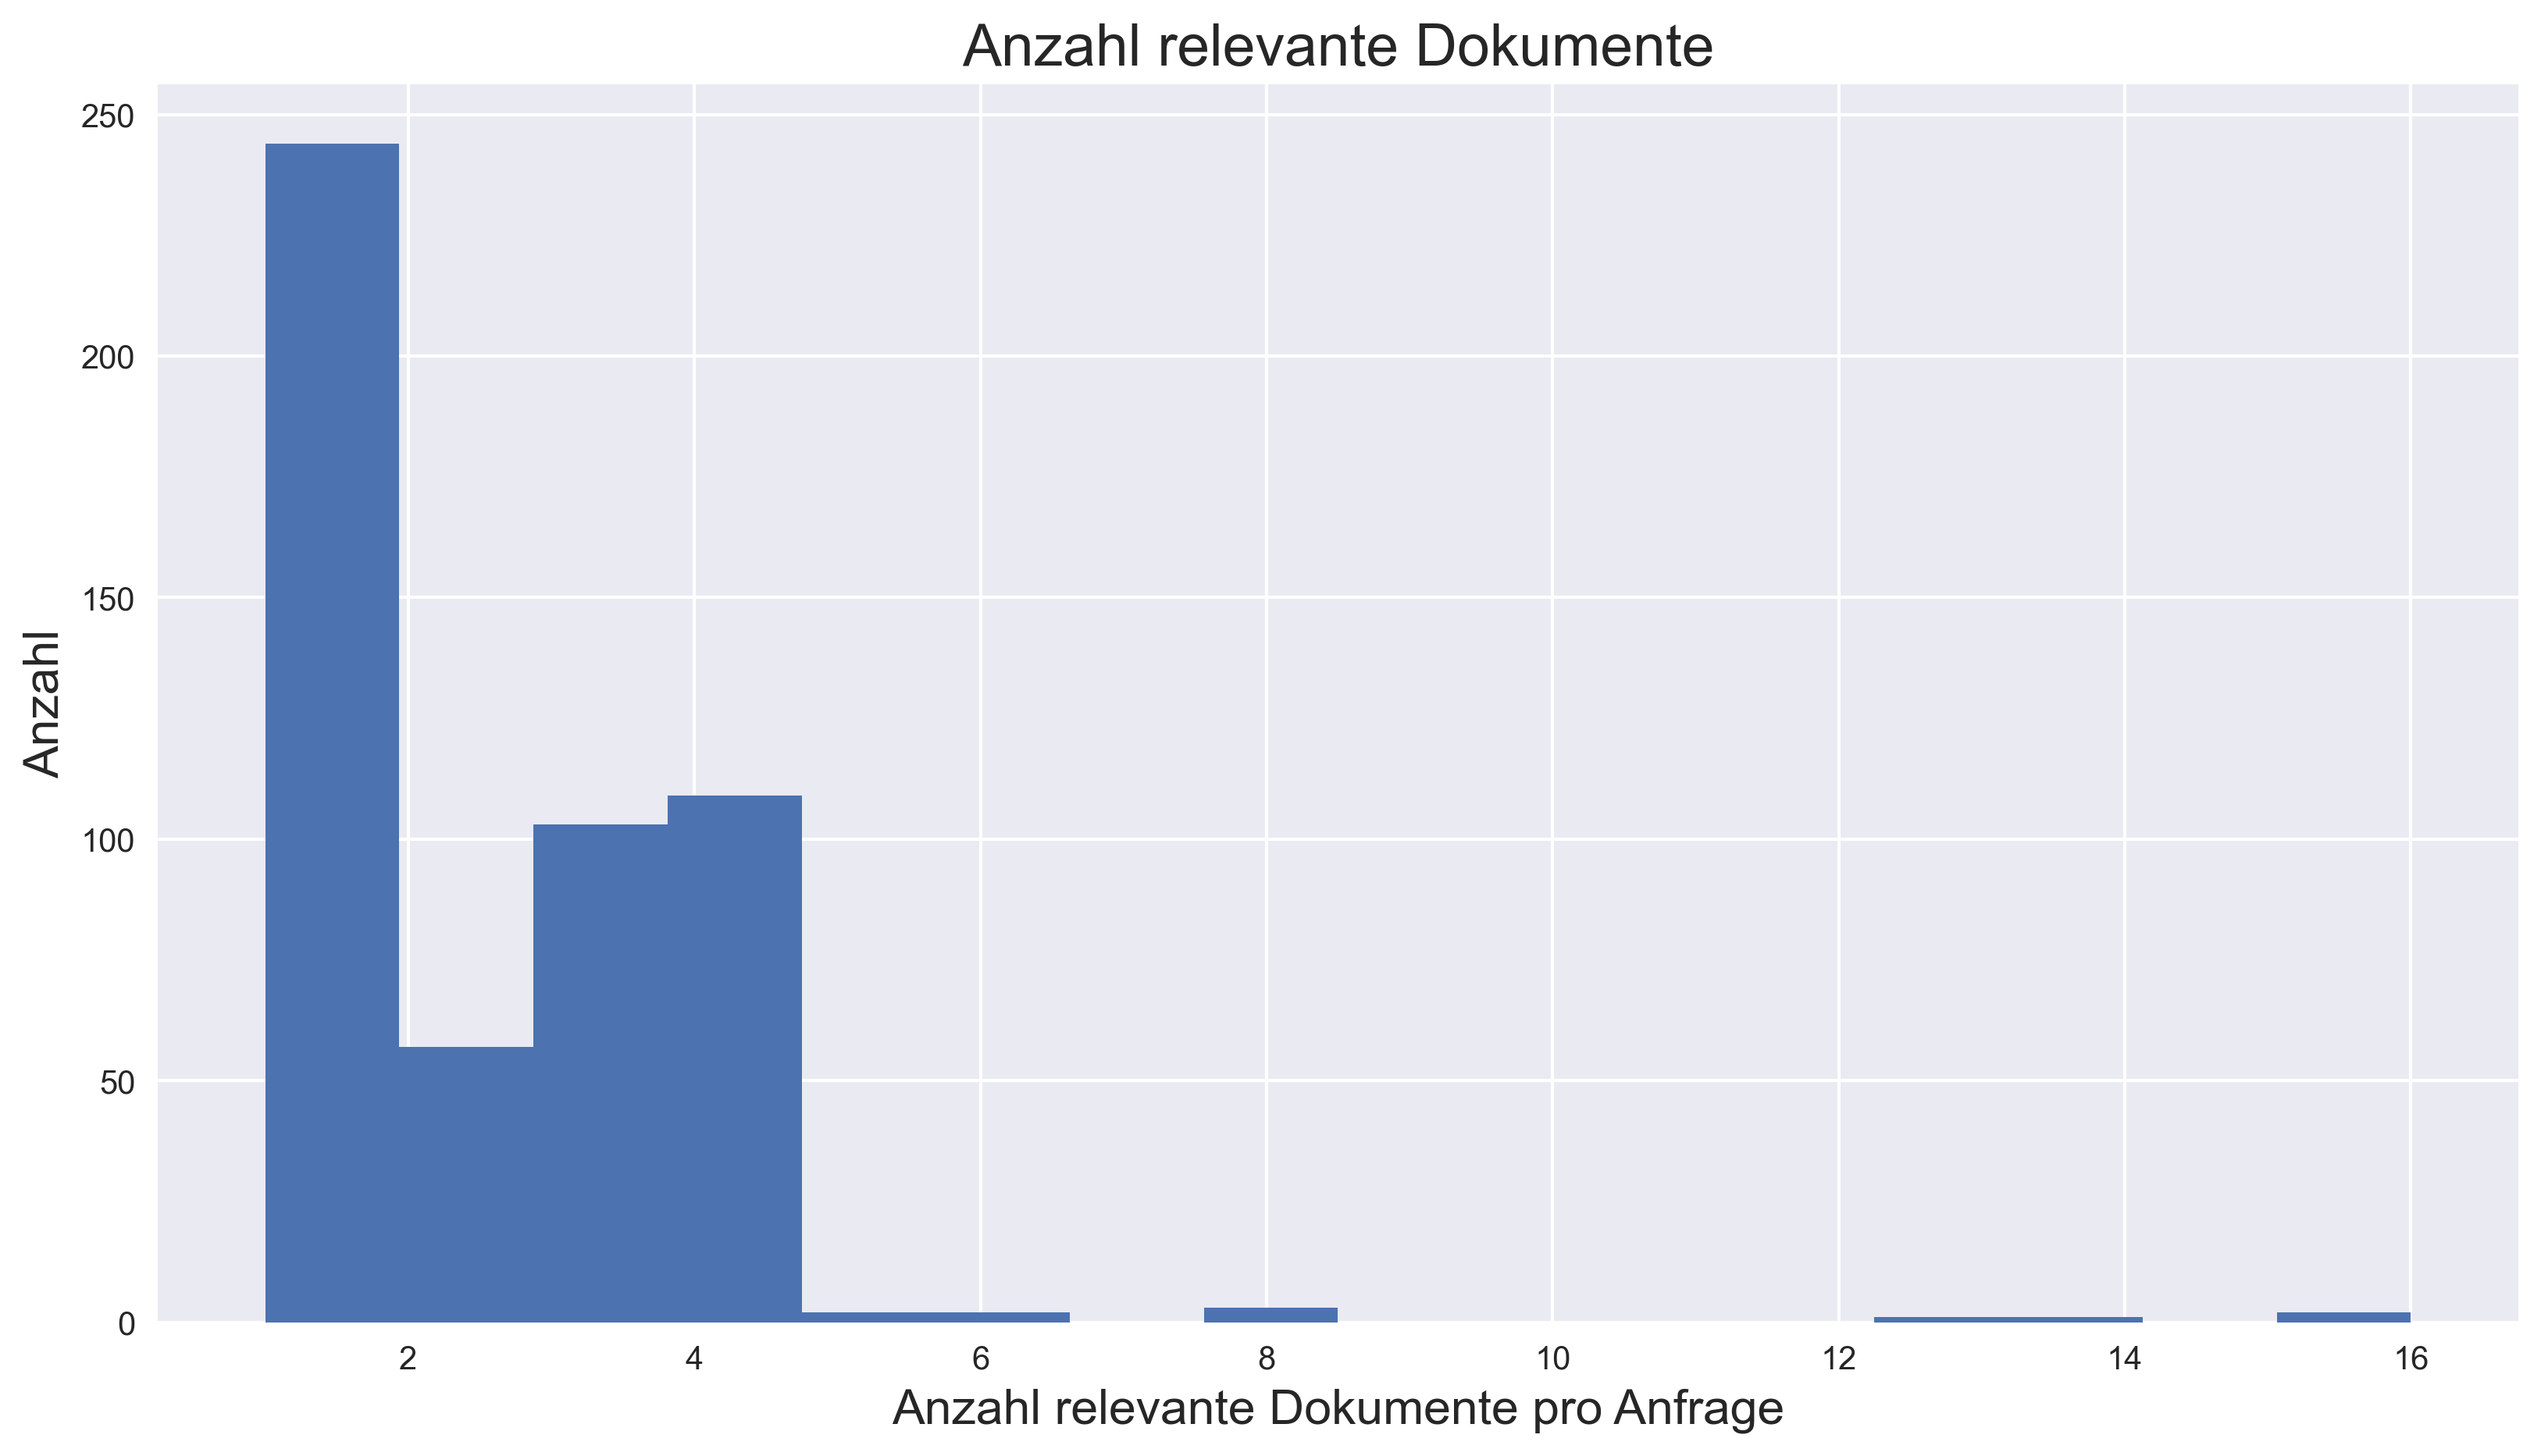

Min: 1 , Max: 16 , Durchschnitt: 2.3053435114503817


In [16]:
#Durchschnittliche Anzahl an relevanten Dokumenten pro Anfrage
lengthsRelevant = []
lengthsQuery = []
for pair in queries:
    lengthsRelevant.append(len(pair[1]))
    lengthsQuery.append(len(word_tokenize(pair[0])))
    

meanRelevantDocuments = np.mean(lengthsRelevant)

plt.figure(figsize=figsize,dpi=dpi)
plt.xlabel('Anzahl relevante Dokumente pro Anfrage',fontsize=labelFontSize)
plt.ylabel('Anzahl',fontsize=labelFontSize)
plt.title('Anzahl relevante Dokumente',fontsize=titleFontSize)
plt.savefig("Matplots/RelevanterAnteil.png",bbox_inches='tight')
plt.hist(lengthsRelevant,bins=16)
plt.show()

print(f'Min: {str(np.min(lengthsRelevant))} , Max: {str(np.max(lengthsRelevant))} , Durchschnitt: {str(meanRelevantDocuments)}')

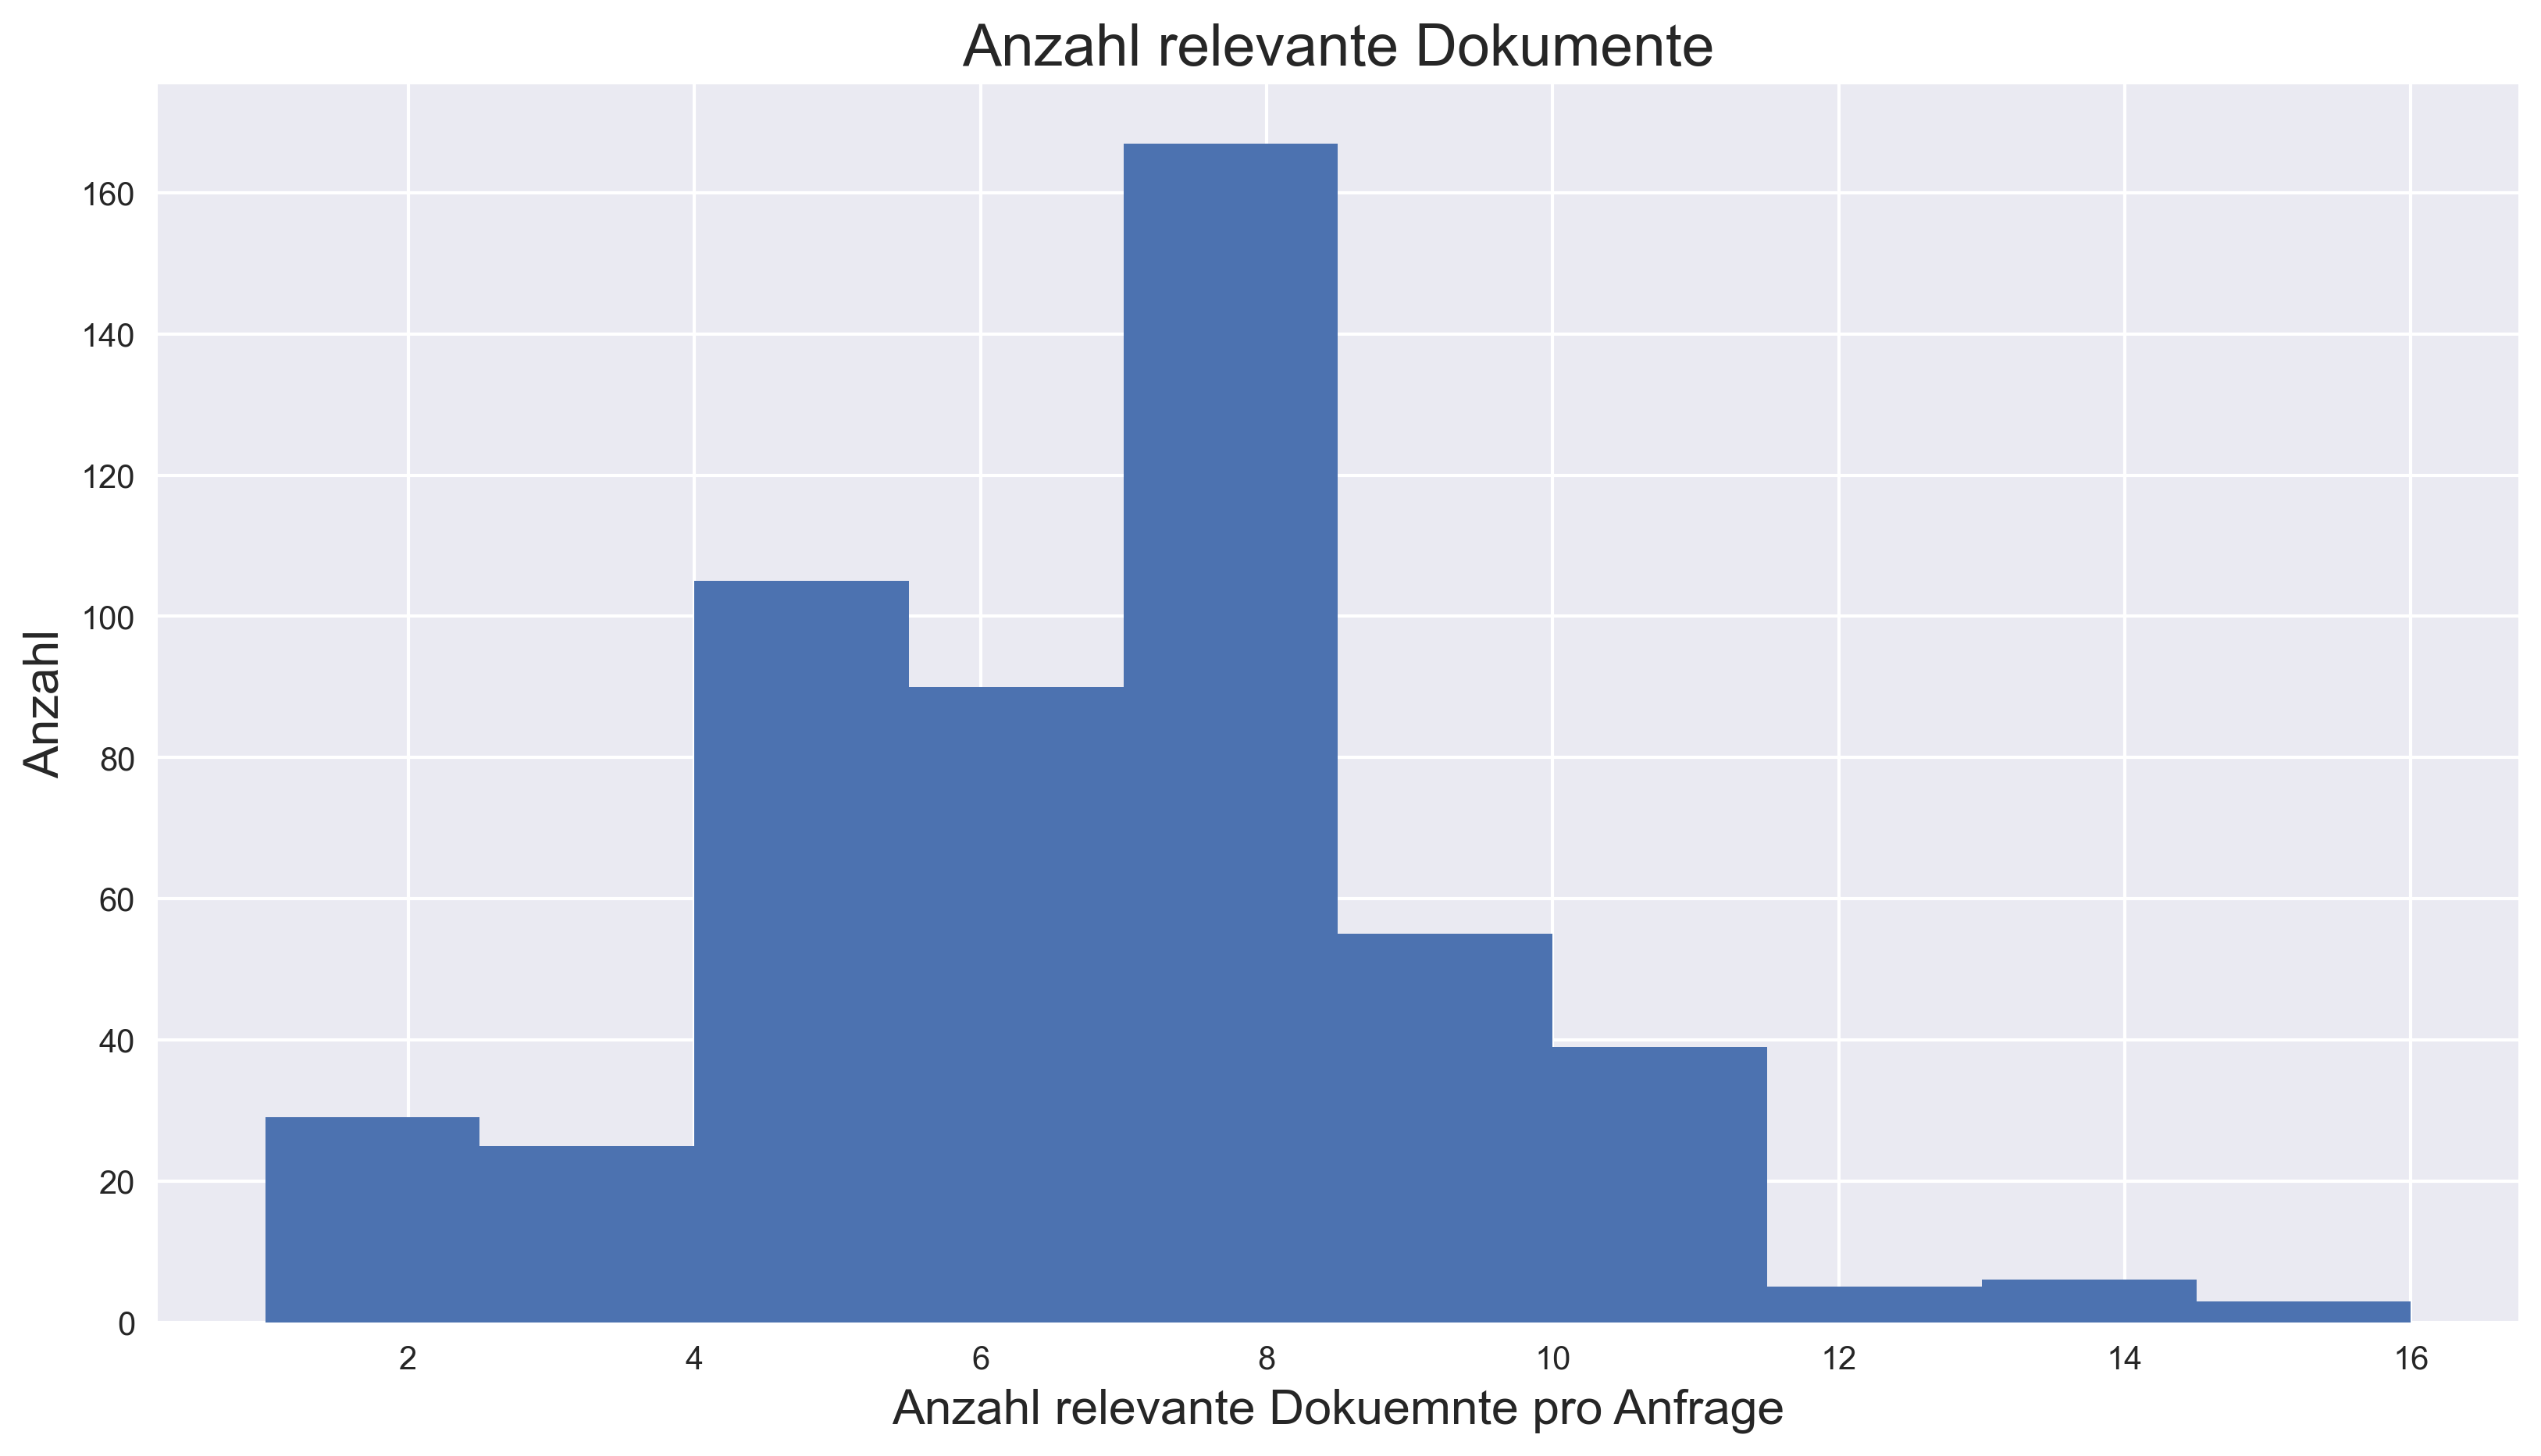

Min: 1 , Max: 16 , Durchschnitt: 6.629770992366412


In [17]:
#Durschnittliche Query Länge
meanQueryLengths = np.mean(lengthsQuery)

plt.figure(figsize=figsize,dpi=dpi)
plt.xlabel('Anzahl relevante Dokuemnte pro Anfrage',fontsize=labelFontSize)
plt.ylabel('Anzahl',fontsize=labelFontSize)
plt.title('Anzahl relevante Dokumente',fontsize=titleFontSize)
plt.savefig("Matplots/RelevanterAnteil.png",bbox_inches='tight')
plt.hist(lengthsQuery,bins=10)
plt.show()

print(f'Min: {str(np.min(lengthsQuery))} , Max: {str(np.max(lengthsQuery))} , Durchschnitt: {str(meanQueryLengths)}')

In [18]:
meanRelevantDocuments = 2.3

#MAP berechnen
def hyper(x,m,n,k):
    return (binom(m,x) * binom(n,k-x)) / binom(m+n,k)

def RandomMAP(N,R):
    ap = 0
    for i in range(1,R+1):
        for n in range(i,N-R+i+1):
            ap = ap + hyper(i,R,N-R,n) * (i/n)*(i/n)
    return ap/R

def randomMRR(relevant, total):
    return relevant / total

def calculateMetrics(relevant, total):
    print(f'MAP: {RandomMAP(total,relevant)}, MRR: {randomMRR(relevant, total)}')

calculateMetrics(10,300)

MAP: 0.050412179769083, MRR: 0.03333333333333333


In [19]:
# TSV-Dateien für Tensorflow-Embedding-Projector vorbereiten
text = []
for key,value in data.items():
    text.append(cleanData(value['content'],True))

text = list(chain.from_iterable(text))
vocab = []
for word in text:
    if word not in vocab:
        vocab.append(word)
        
#vocab = w2vModel.get_words()
with open('Data/Visualization/Vectors.TSV', 'bw') as file_vector, open('Data/Visualization/Words.TSV', 'bw') as file_metadata:
    for word in vocab:
        file_metadata.write((word + '\n').encode('utf-8', errors='replace'))
        vector_row = '\t'.join(str(x) for x in w2vModel.get_word_vector(word))
        file_vector.write((vector_row + '\n').encode('utf-8', errors='replace'))